Please note that due to the complexity of this Project, and considering the time each model/algorithm took to run, and the necessity to perform tasks one at a time, related to memory problems, the notebook's cells are not run in ascending order.

In [1]:
#!pip install mlxtend

In [2]:
#! pip install pmdarima

In [3]:
#!pip install vaex

In [4]:
#!pip install xgboost

In [5]:
#!pip install kmodes

In [6]:
#!pip install permetrics

In [7]:
#!pip install tslearn

In [2]:
#Importing the necessary librabries
import vaex
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpcommon as fpc
import math
import calendar
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from time import time
from datetime import *
from dateutil.relativedelta import *
from tslearn.clustering import KShape
from tslearn.clustering import TimeSeriesKMeans
from kmodes.kmodes import KModes
from permetrics.regression import Metrics
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import statsmodels.api as sm
from itertools import product
from multiprocessing import Pool, cpu_count
import multiprocess as mp
from fbprophet import Prophet

#### Importing Functions to be used in the Quarter Analysis step, that we need to slighlty adapt

In [10]:
#Adapted from https://github.com/rasbt/mlxtend/blob/master/mlxtend/frequent_patterns/apriori.py. 
#Small changes made, namely to allow for a support of 0 to be chosen in function "apriori"
def generate_new_combinations(old_combinations):
    """
    Generator of all combinations based on the last state of Apriori algorithm
    Parameters
    -----------
    old_combinations: np.array
        All combinations with enough support in the last step
        Combinations are represented by a matrix.
        Number of columns is equal to the combination size
        of the previous step.
        Each row represents one combination
        and contains item type ids in the ascending order
        ```
               0        1
        0      15       20
        1      15       22
        2      17       19
        ```
    Returns
    -----------
    Generator of all combinations from the last step x items
    from the previous step.
    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori
    """

    items_types_in_previous_step = np.unique(old_combinations.flatten())
    for old_combination in old_combinations:
        max_combination = old_combination[-1]
        mask = items_types_in_previous_step > max_combination
        valid_items = items_types_in_previous_step[mask]
        old_tuple = tuple(old_combination)
        for item in valid_items:
            yield from old_tuple
            yield item


def generate_new_combinations_low_memory(old_combinations, X, min_support,
                                         is_sparse):
    """
    Generator of all combinations based on the last state of Apriori algorithm
    Parameters
    -----------
    old_combinations: np.array
        All combinations with enough support in the last step
        Combinations are represented by a matrix.
        Number of columns is equal to the combination size
        of the previous step.
        Each row represents one combination
        and contains item type ids in the ascending order
        ```
               0        1
        0      15       20
        1      15       22
        2      17       19
        ```
    X: np.array or scipy sparse matrix
      The allowed values are either 0/1 or True/False.
      For example,
    ```
        0     True False  True  True False  True
        1     True False  True False False  True
        2     True False  True False False False
        3     True  True False False False False
        4    False False  True  True  True  True
        5    False False  True False  True  True
        6    False False  True False  True False
        7     True  True False False False False
    ```
    min_support : float (default: 0.5)
      A float between 0 and 1 for minumum support of the itemsets returned.
      The support is computed as the fraction
      `transactions_where_item(s)_occur / total_transactions`.
    is_sparse : bool True if X is sparse
    Returns
    -----------
    Generator of all combinations from the last step x items
    from the previous step. Every combination contains the
    number of transactions where this item occurs, followed
    by item type ids in the ascending order.
    No combination other than generated
    do not have a chance to get enough support
    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/generate_new_combinations/
    """

    items_types_in_previous_step = np.unique(old_combinations.flatten())
    rows_count = X.shape[0]
    threshold = min_support * rows_count
    for old_combination in old_combinations:
        max_combination = old_combination[-1]
        mask = items_types_in_previous_step > max_combination
        valid_items = items_types_in_previous_step[mask]
        old_tuple = tuple(old_combination)
        if is_sparse:
            mask_rows = X[:, old_tuple].toarray().all(axis=1)
            X_cols = X[:, valid_items].toarray()
            supports = X_cols[mask_rows].sum(axis=0)
        else:
            mask_rows = X[:, old_tuple].all(axis=1)
            supports = X[mask_rows][:, valid_items].sum(axis=0)
        valid_indices = (supports >= threshold).nonzero()[0]
        for index in valid_indices:
            yield supports[index]
            yield from old_tuple
            yield valid_items[index]


def apriori(df, min_support=0.5, max_support=1, use_colnames=False, max_len=None, verbose=0,
            low_memory=False):
    """Get frequent itemsets from a one-hot DataFrame
    Parameters
    -----------
    df : pandas DataFrame
      pandas DataFrame the encoded format. Also supports
      DataFrames with sparse data; for more info, please
      see (https://pandas.pydata.org/pandas-docs/stable/
           user_guide/sparse.html#sparse-data-structures)
      Please note that the old pandas SparseDataFrame format
      is no longer supported in mlxtend >= 0.17.2.
      The allowed values are either 0/1 or True/False.
      For example,
    ```
             Apple  Bananas   Beer  Chicken   Milk   Rice
        0     True    False   True     True  False   True
        1     True    False   True    False  False   True
        2     True    False   True    False  False  False
        3     True     True  False    False  False  False
        4    False    False   True     True   True   True
        5    False    False   True    False   True   True
        6    False    False   True    False   True  False
        7     True     True  False    False  False  False
    ```
    min_support : float (default: 0.5)
      A float between 0 and 1 for minumum support of the itemsets returned.
      The support is computed as the fraction
      `transactions_where_item(s)_occur / total_transactions`.
    use_colnames : bool (default: False)
      If `True`, uses the DataFrames' column names in the returned DataFrame
      instead of column indices.
    max_len : int (default: None)
      Maximum length of the itemsets generated. If `None` (default) all
      possible itemsets lengths (under the apriori condition) are evaluated.
    verbose : int (default: 0)
      Shows the number of iterations if >= 1 and `low_memory` is `True`. If
      >=1 and `low_memory` is `False`, shows the number of combinations.
    low_memory : bool (default: False)
      If `True`, uses an iterator to search for combinations above
      `min_support`.
      Note that while `low_memory=True` should only be used for large dataset
      if memory resources are limited, because this implementation is approx.
      3-6x slower than the default.
    Returns
    -----------
    pandas DataFrame with columns ['support', 'itemsets'] of all itemsets
      that are >= `min_support` and < than `max_len`
      (if `max_len` is not None).
      Each itemset in the 'itemsets' column is of type `frozenset`,
      which is a Python built-in type that behaves similarly to
      sets except that it is immutable
      (For more info, see
      https://docs.python.org/3.6/library/stdtypes.html#frozenset).
    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
    """

    def _support(_x, _n_rows, _is_sparse):
        """DRY private method to calculate support as the
        row-wise sum of values / number of rows
        Parameters
        -----------
        _x : matrix of bools or binary
        _n_rows : numeric, number of rows in _x
        _is_sparse : bool True if _x is sparse
        Returns
        -----------
        np.array, shape = (n_rows, )
        Examples
        -----------
        For usage examples, please see
        http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
        """
        out = (np.sum(_x, axis=0) / _n_rows)
        return np.array(out).reshape(-1)

    if min_support < 0:
        raise ValueError('`min_support` must be a positive '
                         'number within the interval `(0, 1]`. '
                         'Got %s.' % min_support)

    fpc.valid_input_check(df)

    if hasattr(df, "sparse"):
        # DataFrame with SparseArray (pandas >= 0.24)
        if df.size == 0:
            X = df.values
        else:
            X = df.sparse.to_coo().tocsc()
        is_sparse = True
    else:
        # dense DataFrame
        X = df.values
        is_sparse = False
    support = _support(X, X.shape[0], is_sparse)
    ary_col_idx = np.arange(X.shape[1])
    support_dict = {1: support[(support >= min_support) ]}
    itemset_dict = {1: ary_col_idx[(support >= min_support) ].reshape(-1, 1)}
    max_itemset = 1
    rows_count = float(X.shape[0])

    all_ones = np.ones((int(rows_count), 1))

    while max_itemset and max_itemset < (max_len or float('inf')):
        next_max_itemset = max_itemset + 1

        # With exceptionally large datasets, the matrix operations can use a
        # substantial amount of memory. For low memory applications or large
        # datasets, set `low_memory=True` to use a slower but more memory-
        # efficient implementation.
        if low_memory:
            combin = generate_new_combinations_low_memory(
                itemset_dict[max_itemset], X, min_support, is_sparse)
            # slightly faster than creating an array from a list of tuples
            combin = np.fromiter(combin, dtype=int)
            combin = combin.reshape(-1, next_max_itemset + 1)

            if combin.size == 0:
                break
            if verbose:
                print(
                    '\rProcessing %d combinations | Sampling itemset size %d' %
                    (combin.size, next_max_itemset), end="")

            itemset_dict[next_max_itemset] = combin[:, 1:]
            support_dict[next_max_itemset] = combin[:, 0].astype(float) \
                / rows_count
            max_itemset = next_max_itemset
        else:
            combin = generate_new_combinations(itemset_dict[max_itemset])
            combin = np.fromiter(combin, dtype=int)
            combin = combin.reshape(-1, next_max_itemset)

            if combin.size == 0:
                break
            if verbose:
                print(
                    '\rProcessing %d combinations | Sampling itemset size %d' %
                    (combin.size, next_max_itemset), end="")

            if is_sparse:
                _bools = X[:, combin[:, 0]] == all_ones
                for n in range(1, combin.shape[1]):
                    _bools = _bools & (X[:, combin[:, n]] == all_ones)
            else:
                _bools = np.all(X[:, combin], axis=2)

            support = _support(np.array(_bools), rows_count, is_sparse)
            _mask = ((support >= min_support) & (support <= max_support)).reshape(-1)
            if any(_mask):
                itemset_dict[next_max_itemset] = np.array(combin[_mask])
                support_dict[next_max_itemset] = np.array(support[_mask])
                max_itemset = next_max_itemset
            else:
                # Exit condition
                break

    all_res = []
    for k in sorted(itemset_dict):
        support = pd.Series(support_dict[k])
        itemsets = pd.Series([frozenset(i) for i in itemset_dict[k]],
                             dtype='object')

        res = pd.concat((support, itemsets), axis=1)
        all_res.append(res)

    res_df = pd.concat(all_res)
    res_df.columns = ['support', 'itemsets']
    if use_colnames:
        mapping = {idx: item for idx, item in enumerate(df.columns)}
        res_df['itemsets'] = res_df['itemsets'].apply(lambda x: frozenset([
                                                      mapping[i] for i in x]))
    res_df = res_df.reset_index(drop=True)

    if verbose:
        print()  # adds newline if verbose counter was used

    return res_df

# Data anlysis and engineering

### Using Vaex instead of pandas to reduce data size, by limiting strings.

In [11]:
#Importing the data with vaex
data = vaex.from_csv('data.csv', copy_index=False, convert=True, chunk_size=5_000_000)

In [12]:
#Defining the columns which we can reduce the Name and therefore reduce the file's size
colunas = data.column_names[:6]

In [13]:
#Going over the previously selected columns and splitting its names by the "_", keeping what comes after it
for i in colunas:
    data[i]=data[i].apply(lambda x: x.split("_")[1])

In [14]:
#Still in these columns, we can also convert all the values to integers, in order to take up less space
for i in colunas:
    data[i]=data[i].astype("int")

In [15]:
#In the column Measures, replacing its content by 1 if the string there contains "values" and 0 otherwise (meaning it contains "units")
data["Measures"]=data["Measures"].apply(lambda x: 1 if "values" in x else 0)

In [16]:
#Exporting the clean dataset to CSV
data.export_csv("reducedsizeversion.csv")

In [20]:
#Importing the clean dataset with pandas
data = pd.read_csv("reducedsizeversion.csv")

### Joining rows that have quantity and product for the same purchase together, and simplifiyng names of columns.

As requested, we will ignore the SKU and focus at the product Name level

In [21]:
#Rearranging the dataframe to have a column for Family, for Category, for Brand, for Name, for Store, and for Date, ad making a column correspond to Units and another to Value
data = pd.pivot_table(data, index=['ProductFamily_ID', 'ProductCategory_ID', 'ProductBrand_ID','ProductName_ID', 'Point-of-Sale_ID', 'Date'], columns= "Measures", values = "Value",  aggfunc='sum').reset_index()

In [22]:
#Renaming the columns' names
data.rename(columns={"Point-of-Sale_ID":"Store", "ProductFamily_ID": "Family", "ProductCategory_ID": "Category", "ProductName_ID": "Name", "ProductBrand_ID": "Brand", 0: "Quantity", 1:"Value"}, inplace= True)

#Converting the column referent to Date to datetime object
data["Date"]=data["Date"].astype('datetime64[ns]')

#Saving the dataframe as CSV
data.to_csv("daily_data.csv")

### Data exploration

In [23]:
#Importing the dataframe cleaned, with daily data
data = vaex.from_csv('daily_data.csv', copy_index=False, convert=True)

In [25]:
#Deleting the column "Unnamed: 0" and converting the column referent to Date into datetime (as its type was lost during exportation)
data.drop("Unnamed: 0", inplace=True)
data["Date"]=data["Date"].astype('datetime64[ns]')

Let us do a brief describe. It is important to note that the means, std, min and max for the Products' hierarchy (as, for instance, Family) have no meaning.

In [26]:
#using describe() to get information referent to the dataset
data.drop("Date").describe()

Family            Category              Brand  \
data_type               int64               int64              int64   
count                77529407            77529407           77529407   
NA                          0                   0                  0   
mean       10.781284538910507  140.28280474272168  772.3044320460235   
std                  6.534164           64.816384         464.501356   
min                         1                   1                  1   
max                        21                 178               1535   

                         Name               Store            Quantity  \
data_type               int64               int64             float64   
count                77529407            77529407            77529407   
NA                          0                   0                   0   
mean       1465.6171275113713  201.92918875285605  2.5635322865296777   
std                844.899149          121.490739            2.856524   
min                         1                   1                 1.0   
max                      2850                 410               287.0   

                       Value  
data_type            float64  
count               77529407  
NA                         0  
mean       4137.278209680027  
std              8450.573839  
min                    -10.0  
max                 662575.0

We can also see that Prices start on -10, which is very strange. It may be due to a very special promotion, but being strange and residual, we decided the best approach was to remove them.

In [27]:
#Keeping only data whose Values (Prices) are over 0
data = data[data.Value>0]

In [28]:
#Checking for days whose total value was below 50
data[data.Value<50]

#    Family    Category    Brand    Name    Store    Date                              Quantity    Value
0    1         33          1092     2008    50       Timestamp('2019-05-20 00:00:00')  1.0         31.0
1    4         34          279      577     366      Timestamp('2018-01-02 00:00:00')  1.0         15.0
2    4         44          1081     1994    383      Timestamp('2018-12-03 00:00:00')  1.0         1.0
3    12        178         20       55      218      Timestamp('2018-04-15 00:00:00')  1.0         34.0
4    12        178         20       55      219      Timestamp('2018-07-29 00:00:00')  1.0         34.0
...  ...       ...         ...      ...     ...      ...                               ...         ...
498  21        165         1039     1937    211      Timestamp('2019-10-18 00:00:00')  1.0         1.0
499  21        167         174      1905    111      Timestamp('2017-06-21 00:00:00')  1.0         5.0
500  21        167         462      890     111      Timestamp('2017-06-21 00:00:00')  2.0         10.0
501  21        167         541      1060    322      Timestamp('2019-04-30 00:00:00')  2.0         2.0
502  21        170         547      2440    17       Timestamp('2016-09-20 00:00:00')  1.0         10.0

We also noticed that some transactions were suspect: for instance, product 1994 has thousands of purchases with an average price for unit of around 1300 euros, but in one transaction it costed 1 euro. Even if this was a crazy promotion, it won't help to predict stock in the future or to classify stores as top sellers, or even to understand the dynamic of the stores and products, as we know that if we lower prices to a point of discount like the one mentioned, we will sell them either way, independently of the store and what product it is, so those are not interesting for our study. Although ideally we would look at every single product and attempt to understand if any transaction was suspicious (for instance transactions with a 95% of the mean price and above discount), due to limitation of resource, we will not do it, we leave below commented the code to implement it, but we will just look at Products sold under 50 monetary units and verify if for that the price was reasonable or it was an error or liquidation event non interesting for our case. 

In [ ]:
##For the case where we would apply to all the dataset, regardless of the Unit Value amount

# data["Unit_Price"]=data["Value"]/data["Quantity"]
# for sku in data.SKU.unique():
#     price_cutoff=data[data.SKU==sku]["Unit_Price"].mean()*0.05
#     data=data[~((data.SKU==sku)&(data.Unit_Price<price_cutoff))]

In [29]:
#Creatig a column for the Unit Price
data["Unit_Price"]=data["Value"]/data["Quantity"]

#find the names of the products whose Unit Price is below 50
names_search=data[data.Unit_Price<50].Name.unique()

#For the products selected, we will for each define a price cutoff, which we defined as 0.1 * the mean Unit Price, as we considered this as a already too low value to make sense (a 90% promotion)
#Then, we only keep the entries for these products, whose Unit Prices are above the cutoff defined.
for name in names_search:
    price_cutoff=data[data.Name==name]["Unit_Price"].mean()*0.1
    data=data[~((data.Name==name)&(data.Unit_Price<price_cutoff))]
    
    
#We can now lose the column Unit_Price, as its purpose was accomplished.
data.drop("Unit_Price", inplace=True)

### Saving data by week and quarter, with first processing done.

In [32]:
#After these processing, we can save the data at a day level in a CSV
data.export_csv("day.csv")


#Convert the data from vaex to pandas
data = data.to_pandas_df()

#Grouping the data by Weeks, with it starting on Monday, and storing the result into a CSV
data.groupby(["Family", "Category", "Brand", "Name", "Store", pd.Grouper(key='Date', freq='W-MON', label='left')])[['Quantity', "Value"]].sum().reset_index().sort_values('Date').to_csv("weekly.csv")

#Grouping the data by Quarters, and storing the result into a CSV
data.groupby(["Family", "Category", "Brand", "Name",  "Store", pd.Grouper(key='Date', freq='Q', label='left')])[['Quantity', "Value"]].sum().reset_index().sort_values('Date').to_csv("quarterdata.csv")

### Exploring at week level

In [34]:
#Importing the dataset organized by weeks
data = vaex.from_csv('weekly.csv', copy_index=False, convert=True)

In [35]:
#Importing the dataset organized by quarters
data_quarter = vaex.from_csv('quarterdata.csv', copy_index=False, convert=True)

In [36]:
#Deleting extra columns
data.drop("Unnamed: 0", inplace=True)
data_quarter.drop("Unnamed: 0", inplace=True)

#          Family    Category    Brand    Name    Store    Date          Quantity    Value
0          9         178         1054     1964    397      '2015-12-31'  37.0        56671.0
1          12        178         1404     2599    320      '2015-12-31'  2.0         1675.0
2          21        109         363      744     349      '2015-12-31'  1.0         4050.0
3          1         178         880      1709    211      '2015-12-31'  13.0        29657.0
4          12        178         1404     2599    319      '2015-12-31'  10.0        8350.0
...        ...       ...         ...      ...     ...      ...           ...         ...
5,178,054  21        44          635      1260    86       '2019-09-30'  6.0         5882.0
5,178,055  12        178         1240     2335    202      '2019-09-30'  7.0         4669.0
5,178,056  9         178         1299     2406    242      '2019-09-30'  7.0         2378.0
5,178,057  12        178         1240     2335    204      '2019-09-30'  8.0         5336.0
5,178,058  9         178         120      224     258      '2019-09-30'  20.0        6868.0

In [37]:
#Converting the columns referent to Date into datetime object
data["Date"]=data["Date"].astype('datetime64[ns]')
data_quarter["Date"]=data_quarter["Date"].astype('datetime64[ns]')

How many of each thing do we have?

In [38]:
#Checking how many different "labels"  we have per each hierarchy level
for i in data.drop(["Date", "Value", "Quantity"]).column_names:
    print("At", i, "level, we have", len(data[i].unique()))

At Family level, we have 21
At Category level, we have 178
At Brand level, we have 1523
At Name level, we have 2818
At Store level, we have 410
At __Date level, we have 201


Looking at products that are not sold anymore and stores closed to business. 

In [39]:
#Starting by a Product level:

#We prepare a dictionary, with keys as the different Product Names and as values 0 for each one.
nr_weeks_name=dict(zip(data.Name.unique(), [0*i for i in range(len(data.Name.unique()))]))

#Then, we group our dataframe by Date and Name and sum the units sold for each "combination", sorting then by Date.
df_search=data.groupby(data["Date", "Name"], agg=vaex.agg.sum("Quantity")).sort("Date")

#Defining which is the last week for which we have information, overall
last_week_date=pd.Timestamp("2019-10-28T00")

#Going over each Product Name and seeing, through df_search, which was the last week with sales.
#Then, we store in the nr_weeks_name dictionary the number of weeks between the last possible date (28/10/2019) and the one found
for name in nr_weeks_name.keys():
    last_known_date=pd.Timestamp(df_search[df_search.Name==name].Date.values[-1])
    nr_weeks_name[name]=(last_week_date-last_known_date).days//7

In [40]:
#Here, we repeat the same process, but by Store

nr_weeks_store=dict(zip(data.Store.unique(), [0*i for i in range(len(data.Store.unique()))]))

df_search=data.groupby(data["Date", "Store"], agg=vaex.agg.sum("Quantity")).sort("Date")

last_week_date=pd.Timestamp("2019-10-28T00")

for store in nr_weeks_store.keys():
    last_known_date=pd.Timestamp(df_search[df_search.Store==store].Date.values[-1])
    nr_weeks_store[store]=(last_week_date-last_known_date).days//7

In [41]:
#Here, we repeat the same process, but by Brand

nr_weeks_brand=dict(zip(data.Brand.unique(), [0*i for i in range(len(data.Brand.unique()))]))

df_search=data.groupby(data["Date", "Brand"], agg=vaex.agg.sum("Quantity")).sort("Date")

last_week_date=pd.Timestamp("2019-10-28T00")

for brand in nr_weeks_brand.keys():
    last_known_date=pd.Timestamp(df_search[df_search.Brand==brand].Date.values[-1])
    nr_weeks_brand[brand]=(last_week_date-last_known_date).days//7

In [42]:
#Here, we repeat the same process, but by Category

nr_weeks_category=dict(zip(data.Category.unique(), [0*i for i in range(len(data.Category.unique()))]))

df_search=data.groupby(data["Date", "Category"], agg=vaex.agg.sum("Quantity")).sort("Date")

last_week_date=pd.Timestamp("2019-10-28T00")

for category in nr_weeks_category.keys():
    last_known_date=pd.Timestamp(df_search[df_search.Category==category].Date.values[-1])
    nr_weeks_category[category]=(last_week_date-last_known_date).days//7

In [43]:
#Finally, we repeat the same process, but by Family

nr_weeks_family=dict(zip(data.Family.unique(), [0*i for i in range(len(data.Family.unique()))]))

df_search=data.groupby(data["Date", "Family"], agg=vaex.agg.sum("Quantity")).sort("Date")

last_week_date=pd.Timestamp("2019-10-28T00")

for family in nr_weeks_family.keys():
    last_known_date=pd.Timestamp(df_search[df_search.Family==family].Date.values[-1])
    nr_weeks_family[family]=(last_week_date-last_known_date).days//7

We want to be as sure as possible, so we will consider that a product/brand/family/category needs to be inactive for 9 months to not be sold anymore (due to the existance of a seasoal component: for instance, heaters are more sold in the winter and 9 months are enought to reach the same season in two different points in time). Neverthless, for stores we will define the threshold in the 3 months (12 weeks), as it doesn't seem reasonable to wait 9 months to consider it as closed.

In [44]:
#Storing in the respective list the store/name/brand/category/family which hasn't been active for longer than 3 or 9 months (as explained above)
stores_remove = [id_ for id_,weeks in nr_weeks_store.items() if weeks>12]
name_remove = [id_ for id_,weeks in nr_weeks_name.items() if weeks>39]
brand_remove = [id_ for id_,weeks in nr_weeks_brand.items() if weeks>39]
category_remove = [id_ for id_,weeks in nr_weeks_category.items() if weeks>39]
family_remove = [id_ for id_,weeks in nr_weeks_family.items() if weeks>39]

In [45]:
#Checking how many Product Names we are considering as inactive
len(name_remove)

558

In [46]:
#Checking how many Stores we are considering as inactive
len(stores_remove)

1

In [47]:
#Checking how many Product Brands we are considering as inactive
len(brand_remove)

312

In [48]:
#Checking how many Product Categories we are considering as inactive
len(category_remove)

13

In [49]:
#Checking how many Product Families we are considering as inactive
len(family_remove)

0

In [50]:
#Thinking ahead, it does not make sense to consider the Names, Categories and Brands which are not sold for more than 9 months to our forecast problem.

#Storing in a dataframe the ids of the Names, Categories and Brands and then exporting it to CSV, to later on take into consideration.
df1=pd.DataFrame({"Name":name_remove})
df3=pd.DataFrame({"Category":category_remove})
df4=pd.DataFrame({"Brand":brand_remove})

remove_forecast=pd.concat([df1,df3,df4], axis=1)
remove_forecast.to_csv("remove_forecast.csv")

del df1, df3, df4

We will now look just at the "closed" store, which seems has stopped doing business in April

In [51]:
#Selecting the store which we considered as closed
selection=stores_remove[0]

#Access the data from this store
df = data[data.Store==selection]

#Re-arranging the data to plot it and doing it
df_plot = df.groupby(df["Date", "Store"], agg=vaex.agg.sum('Quantity')).to_pandas_df().sort_values(by='Date')
fig= go.Figure([go.Scatter(x=df_plot["Date"], y=df_plot["Quantity_sum"])])
fig.show()

We will remove the closed store, as there is no interest in analysing how this one behaved, the "damage" is  done and it is closed, being that we don't even know the reason for closure, it may have nothing to do with the value it brought. Regarding the products (and others hierarchies), we will use them as part of our analysis until the forecast part. The reasoning is that it is still relevant to analyse it from the historical perspective, for instance to understand that a specific store is the best selling a specific category/brand (even though some products from that category/brand were already discontinued), as that still help us understand the customers preferences on that stores and may even raise the case to bring back those products or if not possible to find substitutes or make more alike campaigns (it may have been a limited edition product, for instance).

In [52]:
#Removing the store which we considered as closed from the data dataset
data = data[~(data.Store == stores_remove[0])]

In [53]:
#Removing it also from the dataset with data grouped by quarter
data_quarter = data_quarter[~(data_quarter.Store == stores_remove[0])]

In [54]:
#Saving the files to CSV
data_quarter.export_csv("data_quarter.csv")
data.export_csv("data.csv")

# Quarter Analysis

In [4]:
#Importing the dataset at a quarter level
quarter_data=pd.read_csv('data_quarter.csv')

#Replacing values in date column with quarter's "names" 
date_replace_dict = {'2015-12-31':'Q1_2016', '2016-03-31':'Q2_2016', '2016-06-30':'Q3_2016', '2016-09-30':'Q4_2016',
                     '2016-12-31':'Q1_2017', '2017-03-31':'Q2_2017', '2017-06-30':'Q3_2017', '2017-09-30':'Q4_2017',
                     '2017-12-31':'Q1_2018', '2018-03-31':'Q2_2018', '2018-06-30':'Q3_2018', '2018-09-30':'Q4_2018',
                     '2018-12-31':'Q1_2019', '2019-03-31':'Q2_2019', '2019-06-30':'Q3_2019', '2019-09-30':'Q4_2019'}

quarter_data['Date'] = quarter_data['Date'].map(date_replace_dict)

### Top Products Sold

In [5]:
#Creating a dataframe where we have the data grouped by Store, Quarter and Name of the Product
quarter_data_grouped = quarter_data[['Quantity','Value']].groupby(by=[quarter_data['Store'],
                                                                      quarter_data['Date'],
                                                                      quarter_data['Name']]).sum()
quarter_data_grouped.reset_index(inplace=True)


#Fuction to return a table with Top 5 in quantity and Top 5 in Value, for a chosen Store and Quarter
def top_products(Store, Date):
    """This function receives the the Id of a Store (integer) and the Quarter in study in the format 'QX_YYYY'.
    It returns 2 tables, according to the selection made:
    First, a table with the 5 products which were sold the most.
    Secondly, a table with the 5 products which brought the most money."""
    
    #Slicing the dataframe quarter_data_grouped according to the user's input.
    top_data = quarter_data_grouped.get((quarter_data_grouped.Store == Store) & (quarter_data_grouped.Date == Date))
    
    #Getting the top 5 items
    top5_qty = top_data[['Name', 'Quantity']].nlargest(n=5, columns=['Quantity'])
    top5_value = top_data[['Name', 'Value']].nlargest(n=5, columns=['Value'])
    
    #Creating the figure
    fig = make_subplots(
    rows=1,
    cols=2,
    shared_xaxes=True,
    horizontal_spacing=0.03,
    specs=[[{"type": "table"},{"type": "table"}]],
    subplot_titles=("Top 5 In Quantity", "Top 5 in Value")
    )

    #Adding the table referent to the Quantity
    fig.add_trace(
        go.Table(
            header=dict(values=top5_qty.columns,
                font=dict(size=13),
                align="left"
            ),
            cells=dict(
                values=[top5_qty[k].tolist() for k in top5_qty.columns],
                align = "left")
        ),
        row=1, col=1
    )

    #Adding the table referent to the Value
    fig.add_trace(
        go.Table(
            header=dict(values=top5_value.columns,
                font=dict(size=13),
                align="left"
            ),
            cells=dict(
                values=[top5_value[k].tolist() for k in top5_value.columns],
                align = "left")
        ),
        row=1, col=2
    )

    #Some layout changes
    fig.update_layout(height=350, width=800,
                      title_text='Top 5 Products Names in Store ' + str(Store) + ' in ' + Date)

    return fig

In [6]:
#Applying the function to the Store 8, in Quarter 2 of 2016, as an example.
top_products(8, 'Q2_2016')

INFO:MainThread:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:MainThread:numexpr.utils:NumExpr defaulting to 8 threads.


### Market Share (Family, Category)

In [7]:
#Function to return a treemap with the decomposition of the Families by quantity, for a chosen store and quarter
def market_share_family(Store, Date):
    """This function receives a Store ID (integer) and a Quarter (in the format "QX_YYYY").
    For the selection made, it returns a treemap with the decomposition of each Family's market share, taking into consideration the Quantity sold."""
    
    #Slicing the dataframe with the user's input
    family_data = quarter_data.get((quarter_data.Store == Store) & (quarter_data.Date == Date))

    #Grouping the data by Family
    family_grouped = family_data[['Quantity']].groupby(by=[family_data['Family']]).sum().reset_index()
    
    #Finding the total amount sold
    total_store = sum(family_grouped['Quantity'])
    
    #Getting the market share
    family_grouped['Market_Share'] = (family_grouped['Quantity']/total_store)*100
    mkt_share_family = family_grouped[['Family', 'Market_Share']].sort_values(by='Market_Share', ascending=False)
        
    #Ploting the data
    fig = px.treemap(mkt_share_family, path=['Family'], values='Market_Share',
                     title='Family Market Share in Store ' + str(Store) + ' in ' + Date)
    
    return fig.show()

In [8]:
#Applying the function for the Store 21, in the 2nd Quarter of 2018, as an example
market_share_family(21,'Q2_2018')

In [9]:
#Doing the Smae, but for the Category
def market_share_category(Store, Date):
    """This function receives a Store ID (integer) and a Quarter (in the format "QX_YYYY").
    For the selection made, it returns a treemap with the decomposition of each Category's market share, taking into consideration the Quantity sold."""
    
    category_data = quarter_data.get((quarter_data.Store == Store) & (quarter_data.Date == Date))

    category_grouped = category_data[['Quantity']].groupby(by=[category_data['Category']]).sum().reset_index()
    total_store = sum(category_grouped['Quantity'])
    category_grouped['Market_Share'] = (category_grouped['Quantity']/total_store)*100
    
    mkt_share_category = category_grouped[['Category', 'Market_Share']].sort_values(by='Market_Share', ascending=False)
      
    # Plot
    fig = px.treemap(mkt_share_category, path=['Category'], values='Market_Share',
                     title='Category Market Share in Store ' + str(Store) + ' in ' + Date)
  
    return fig.show()

In [10]:
#Applyig the function for the Store 87, in the 2nd Quarter of 2018
market_share_category(87, 'Q2_2018')

## Market Basket Analysis

In [11]:
#Starting by getting a TID, which, as indicated by the company, should be formed by Quarter and Store
cols = ['Store', 'Date']
quarter_data['TID'] = quarter_data[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

#Removing the columns which have no interest for the MBA
data_mba = quarter_data.drop(columns=['Date', 'Store', 'Value', 'Quantity', 'Name', 'Brand'])
data_mba.head()

Family  Category          TID
0       9       178  397_Q1_2016
1      12       178  320_Q1_2016
2      21       109  349_Q1_2016
3       1       178  211_Q1_2016
4      12       178  319_Q1_2016

### MBA - Family

In [12]:
#Re-formating the data into the right format to be analysed in the MBA.
data_pivot_family = pd.pivot_table(data_mba[["TID", "Family"]], index='TID', columns='Family',
                            aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
data_pivot_family.head()

Family        1    2    3    4    5    6    7    8    9    10  ...   12   13  \
TID                                                            ...             
100_Q1_2016  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
100_Q1_2017  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
100_Q1_2018  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
100_Q1_2019  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
100_Q2_2016  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   

Family        14   15   16   17   18   19   20   21  
TID                                                  
100_Q1_2016  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  
100_Q1_2017  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
100_Q1_2018  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
100_Q1_2019  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
100_Q2_2016  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  

[5 rows x 21 columns]

#### Substitutes

In [26]:
def substitutes_family(quarter=None):
    """This function receives as input a Quarter, in the format 'QX_YYYY', or no value at all, 
    performing the analysis at a global level.
    Doing the analysis at a Family level, through the Appriori algorithm, it selects the names which have 
    a minimum support of 10%. 
    Then, recurring again to the Appriori algorithm, it finds the pairs of products whose min_support is 0. 
    Finally, it returns the association rules found, by considering as maximum value of lift, 0.975, in order to find the
    substitutes."""
    
    #Slicing the dataset data_pivot_family according to the user's choice.
    if quarter == None:
        data_subs_family = data_pivot_family
    else: 
        data_subs_family = data_pivot_family.get(data_pivot_family.index.str.contains(quarter))
    
    #Applying the apriori algorithm to the data_subs_family dataframe.
    #We defined the support to be at leat 10% (however this does not have impact since all the families have a high support)  and the max_len as 1
    frequent_items_family = apriori(data_subs_family, min_support=0.1,use_colnames=True, max_len=1)

    #Storing the names of the product families that passed the "test"
    products_names=[]
    for product in frequent_items_family["itemsets"]:
        products_names.append(list(product)[0])

    #Slicing the data_subs_family dataframe to only keep the products that passed the "test"
    data_pivot_sliced = data_subs_family.loc[:,products_names]

    #Now, we re-apply the apriori algorithm to our data_pivot_sliced dataframe.
    #We define the min_support as 0, due to being interested in finding the products which are substitutes (if the two products are substitutes, it makes sense for them not to be bought together in a minimum percentage of orders)
    #We define max_len=2, because we are interested in having the pairs of products which are substitutes
    data_for_subs_family = apriori(data_pivot_sliced, min_support=0,  use_colnames=True, max_len=2, low_memory=True)

    #Generating the association rules for our data_for_subs_family dataframe. 
    #Note that we define as min_threshold 0, because, as said before, we are interested in substitutes products, and therefore the only minimum value the lift has to have is 0.
    ruleslift_family = association_rules(data_for_subs_family, metric="lift", min_threshold=0)

    #sorting the values by ascending order, according to the lif
    ruleslift_family.sort_values(by='lift', ascending=True, inplace=True)

    #Applying our criteria to consider two products as substitutes:
    subs_family = ruleslift_family[((ruleslift_family["lift"]<0.975))].drop("conviction", axis=1)

    return subs_family

In [27]:
#Checking for substitutes in the 3rd Quarter of 2018: None were found
substitutes_family('Q3_2018')

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage]
Index: []

In [28]:
#Checking for substitutes in the 4th Quarter of 2018: None were found
substitutes_family('Q4_2018')

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage]
Index: []

In [29]:
#Checking for substitutes in the 1st Quarter of 2019: None were found
substitutes_family('Q1_2019')

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage]
Index: []

In [30]:
#Checking for substitutes in the 2nd Quarter of 2019: None were found
substitutes_family('Q2_2019')

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage]
Index: []

#### Complementary

In [31]:
def complementary_family(quarter=None):
    """This function receives as input a Quarter, in the format 'QX_YYYY', or no value at all, 
    performing the analysis at a global level.
    Doing the analysis at a Family level, through the Appriori algorithm, it finds the subsets whose min_support is 10% and the
    max_len is 4. 
    Finally, it returns the association rules found, by considering as minimum value of lift, 1.05 and the confidence as 0.9, in
    order to find the complementaries."""
    

    if quarter == None:
        data_comp_family = data_pivot_family
    else: 
        data_comp_family = data_pivot_family.get(data_pivot_family.index.str.contains(quarter))    
    
    #We defined the support to be at leat 10% (however this does not have impact since all the families have a high support) and the max_len as 4 due to efficiency costs
    frequent_itemsets_family = apriori(data_comp_family, min_support=0.1 ,use_colnames=True, max_len=4, low_memory=True)

    #Getting the association rules for the items in frequent_itemsets_family, using as metric the lift and defining the min_threshold as 0
    ruleslift_itemsets_family = association_rules(frequent_itemsets_family, metric="lift", min_threshold=0)

    #Sorting for ascending order, regarding the lift
    ruleslift_itemsets_family.sort_values(by='lift', ascending=True, inplace=True)

    #Setting the criteria for rules selection
    comp_family = ruleslift_itemsets_family[((ruleslift_itemsets_family["lift"]>1.05)&(ruleslift_itemsets_family["confidence"]>0.9))].drop("conviction", axis=1)

    
    return comp_family

In [32]:
#Checking for complentary Families in the 3rd Quarter of 2018: None were found
complementary_family('Q3_2018')

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage]
Index: []

In [33]:
#Checking for complentary Families in the 4th Quarter of 2018: None were found
complementary_family('Q4_2018')

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage]
Index: []

In [34]:
#Checking for complentary Families in the 1st Quarter of 2019: None were found
complementary_family('Q1_2019')

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage]
Index: []

In [35]:
#Checking for complentary Families in the 2nd Quarter of 2019: None were found
complementary_family('Q2_2019')

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage]
Index: []

### MBA - Category 

In [36]:
#Repeating the process for the Category intead of the Family
data_pivot_category = pd.pivot_table(data_mba[["TID", "Category"]], index='TID', columns='Category',
                            aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)

data_pivot_category.head()

Category     1    2    3    4    5    6    7    8    9    10   ...  169  170  \
TID                                                            ...             
100_Q1_2016  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  ...  1.0  0.0   
100_Q1_2017  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  ...  1.0  1.0   
100_Q1_2018  1.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  ...  0.0  0.0   
100_Q1_2019  1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  ...  1.0  0.0   
100_Q2_2016  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  ...  1.0  1.0   

Category     171  172  173  174  175  176  177  178  
TID                                                  
100_Q1_2016  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
100_Q1_2017  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
100_Q1_2018  0.0  1.0  1.0  0.0  1.0  0.0  0.0  1.0  
100_Q1_2019  0.0  1.0  1.0  0.0  1.0  0.0  0.0  1.0  
100_Q2_2016  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  

[5 rows x 178 columns]

#### Substitutes

In [51]:
def substitutes_category(quarter=None):

    """This function receives as input a Quarter, in the format 'QX_YYYY', or no value at all, performing the analysis at a global level.Doing the analysis at a Category level, through the Appriori algorithm, it selects the names which have a minimum support of 5%. Then, recurring again to the Appriori algorithm, it finds the pairs of products whose min_support is 0. Finally, it returns the association rules found, by considering as maximum value of lift, 0.9, and of confidence, 0.2, in order to find the substitutes."""
  
    
    if quarter == None:
        data_subs_category = data_pivot_category
    else: 
        data_subs_category = data_pivot_category.get(data_pivot_category.index.str.contains(quarter))
    
    #Applying the apriori algorithm to the data_pivot_category dataframe.
    #We defined the min_support 5% and the max_len as 1 
    frequent_items_category = apriori(data_subs_category, min_support=0.05,use_colnames=True, max_len=1)

    #Storing the names of the products that passed the "test"
    products_names=[]
    for product in frequent_items_category["itemsets"]:
        products_names.append(list(product)[0])

    #Slicing the ata_subs_category dataframe to only keep the products that passed the "test"
    data_pivot_sliced= data_subs_category.loc[:,products_names]

    #Now, we re-apply the apriori algorithm to our data_pivot_sliced dataframe.
    #We define the min_support as 0, due to being interested in finding the products which are substitutes (if the two products are substitutes, it makes sense for them not to be bought together in a minimum percentage of orders)
    #We define max_len=2, because we are interested in having the pairs of products which are substitutes
    data_for_subs_category = apriori(data_pivot_sliced, min_support=0,  use_colnames=True, max_len=2, low_memory=True)

    #Generating the association rules for our data_for_subs_category dataframe. 
    #Note that we define as min_threshold 0, because, as said before, we are interested in substitutes products, and therefore the only minimum value the lift has to have is 0.
    ruleslift_category = association_rules(data_for_subs_category, metric="lift", min_threshold=0)

    #sorting the values by ascending order, accoridng to the lif
    ruleslift_category.sort_values(by='lift', ascending=True, inplace=True)

    #Applying our criteria to consider two products as substitutes:
    subs_category = ruleslift_category[((ruleslift_category["lift"]<0.9) & (ruleslift_category["confidence"]<0.2))].drop("conviction", axis=1)
 
    return subs_category

In [52]:
#Checking for substitutes in the 3rd Quarter of 2018
subs_cat_Q3_2018 = substitutes_category('Q3_2018')
subs_cat_Q3_2018

antecedents consequents  antecedent support  consequent support  \
20370       (170)       (159)            0.090465            0.051345   
20371       (159)       (170)            0.051345            0.090465   
13251       (159)        (72)            0.051345            0.078240   
13250        (72)       (159)            0.078240            0.051345   
16139       (159)        (98)            0.051345            0.073350   
...           ...         ...                 ...                 ...   
1280          (5)       (102)            0.638142            0.215159   
6536         (32)       (169)            0.369193            0.178484   
10790        (56)       (121)            0.396088            0.117359   
7904         (38)       (159)            0.691932            0.051345   
16586       (105)       (121)            0.278729            0.117359   

        support  confidence      lift  leverage  
20370  0.000000    0.000000  0.000000 -0.004645  
20371  0.000000    0.000000  0.000000 -0.004645  
13251  0.000000    0.000000  0.000000 -0.004017  
13250  0.000000    0.000000  0.000000 -0.004017  
16139  0.000000    0.000000  0.000000 -0.003766  
...         ...         ...       ...       ...  
1280   0.122249    0.191571  0.890369 -0.015053  
6536   0.058680    0.158940  0.890502 -0.007215  
10790  0.041565    0.104938  0.894162 -0.004920  
7904   0.031785    0.045936  0.894666 -0.003742  
16586  0.029340    0.105263  0.896930 -0.003372  

[93 rows x 8 columns]

In [53]:
#checking the top 10 antecedents
subs_cat_Q3_2018.antecedents.value_counts().head(10)

(159)    12
(61)      7
(5)       6
(106)     5
(72)      5
(102)     4
(170)     4
(155)     3
(121)     3
(83)      3
Name: antecedents, dtype: int64

In [54]:
#checking the top 10 consequents
subs_cat_Q3_2018.consequents.value_counts().head(10)

(159)    23
(121)    11
(61)      8
(106)     7
(72)      5
(102)     5
(170)     5
(83)      4
(155)     3
(51)      3
Name: consequents, dtype: int64

In [55]:
#Checking for substitutes in the 4th Quarter of 2018
subs_cat_Q4_2018 = substitutes_category('Q4_2018')
subs_cat_Q4_2018

antecedents consequents  antecedent support  consequent support  \
15898       (121)        (98)            0.078240            0.063570   
13421        (76)       (104)            0.122249            0.058680   
13420       (104)        (76)            0.058680            0.122249   
18030       (121)       (169)            0.078240            0.075795   
18031       (169)       (121)            0.075795            0.078240   
...           ...         ...                 ...                 ...   
13212        (72)       (177)            0.100244            0.136919   
13213       (177)        (72)            0.136919            0.100244   
13925       (121)        (80)            0.078240            0.105134   
13924        (80)       (121)            0.105134            0.078240   
9801         (50)       (104)            0.278729            0.058680   

        support  confidence      lift  leverage  
15898  0.000000    0.000000  0.000000 -0.004974  
13421  0.000000    0.000000  0.000000 -0.007174  
13420  0.000000    0.000000  0.000000 -0.007174  
18030  0.000000    0.000000  0.000000 -0.005930  
18031  0.000000    0.000000  0.000000 -0.005930  
...         ...         ...       ...       ...  
13212  0.012225    0.121951  0.890679 -0.001500  
13213  0.012225    0.089286  0.890679 -0.001500  
13925  0.007335    0.093750  0.891715 -0.000891  
13924  0.007335    0.069767  0.891715 -0.000891  
9801   0.014670    0.052632  0.896930 -0.001686  

[117 rows x 8 columns]

In [56]:
#checking the top 10 antecedents
subs_cat_Q4_2018.antecedents.value_counts().head(10)

(121)    15
(30)      7
(104)     7
(83)      6
(41)      5
(106)     5
(43)      4
(51)      4
(131)     4
(72)      4
Name: antecedents, dtype: int64

In [57]:
#checking the top 10 consequents
subs_cat_Q4_2018.consequents.value_counts().head(10)

(121)    26
(104)    10
(83)      7
(30)      7
(106)     6
(98)      6
(51)      5
(43)      4
(169)     4
(72)      4
Name: consequents, dtype: int64

In [58]:
#Checking for substitutes in the 1st Quarter of 2019
subs_cat_Q1_2019 = substitutes_category('Q1_2019')
subs_cat_Q1_2019

antecedents consequents  antecedent support  consequent support  \
12422        (72)       (106)            0.083130            0.092910   
12423       (106)        (72)            0.092910            0.083130   
5980        (121)        (30)            0.105134            0.073350   
5981         (30)       (121)            0.073350            0.105134   
11143       (158)        (61)            0.124694            0.058680   
11142        (61)       (158)            0.058680            0.124694   
17172       (121)       (158)            0.105134            0.124694   
17173       (158)       (121)            0.124694            0.105134   
12511       (158)        (72)            0.124694            0.083130   
12510        (72)       (158)            0.083130            0.124694   
17198       (177)       (121)            0.144254            0.105134   
17199       (121)       (177)            0.105134            0.144254   
9404        (130)        (51)            0.134474            0.097800   
9405         (51)       (130)            0.097800            0.134474   
5890         (61)        (30)            0.058680            0.073350   
5891         (30)        (61)            0.073350            0.058680   
9321         (76)        (51)            0.129584            0.097800   
9320         (51)        (76)            0.097800            0.129584   
18415       (140)       (169)            0.095355            0.124694   
18414       (169)       (140)            0.124694            0.095355   
9286         (51)        (54)            0.097800            0.102689   
9287         (54)        (51)            0.102689            0.097800   
7075         (35)       (106)            0.562347            0.092910   
10005        (54)       (140)            0.102689            0.095355   
10004       (140)        (54)            0.095355            0.102689   
12991       (158)        (76)            0.124694            0.129584   
12990        (76)       (158)            0.129584            0.124694   
10032       (158)        (54)            0.124694            0.102689   
10033        (54)       (158)            0.102689            0.124694   
13470        (80)       (169)            0.100244            0.124694   
13471       (169)        (80)            0.124694            0.100244   
9362        (106)        (51)            0.092910            0.097800   
9363         (51)       (106)            0.097800            0.092910   
5683         (29)        (76)            0.393643            0.129584   
1303          (5)       (140)            0.782396            0.095355   
5643         (29)        (51)            0.393643            0.097800   
15818       (106)       (140)            0.092910            0.095355   
15819       (140)       (106)            0.095355            0.092910   
12449       (121)        (72)            0.105134            0.083130   
12448        (72)       (121)            0.083130            0.105134   
15343       (100)       (140)            0.273839            0.095355   
9299         (61)        (51)            0.058680            0.097800   
9298         (51)        (61)            0.097800            0.058680   
11582        (64)       (106)            0.273839            0.092910   
9477         (51)       (177)            0.097800            0.144254   
9476        (177)        (51)            0.144254            0.097800   
11115        (61)       (140)            0.058680            0.095355   
11114       (140)        (61)            0.095355            0.058680   
17820       (130)       (158)            0.134474            0.124694   
17821       (158)       (130)            0.124694            0.134474   
12464        (72)       (130)            0.083130            0.134474   
12465       (130)        (72)            0.134474            0.083130   
9402        (128)        (51)            0.557457            0.097800   

        support  confidence      lift  leverage  
12422  0.0024

In [59]:
#checking the top 10 antecedents
subs_cat_Q1_2019.antecedents.value_counts().head(10)

(51)     6
(158)    6
(72)     4
(121)    4
(61)     4
(140)    4
(106)    3
(130)    3
(54)     3
(30)     2
Name: antecedents, dtype: int64

In [60]:
#checking the top 10 consequents
subs_cat_Q1_2019.consequents.value_counts().head(10)

(51)     8
(140)    6
(158)    6
(106)    5
(61)     4
(121)    4
(72)     4
(130)    3
(76)     3
(54)     3
Name: consequents, dtype: int64

In [61]:
#Checking for substitutes in the 2nd Quarter of 2019
subs_cat_Q2_2019 = substitutes_category('Q2_2019')
subs_cat_Q2_2019

antecedents consequents  antecedent support  consequent support  \
8771         (47)       (106)            0.053790            0.056235   
8770        (106)        (47)            0.056235            0.053790   
16447       (155)       (106)            0.114914            0.056235   
16446       (106)       (155)            0.056235            0.114914   
16449       (156)       (106)            0.100244            0.056235   
...           ...         ...                 ...                 ...   
3732         (16)       (156)            0.777506            0.100244   
16475       (173)       (106)            0.885086            0.056235   
7235         (36)        (98)            0.427873            0.090465   
9480         (50)       (155)            0.378973            0.114914   
19722       (160)       (155)            0.757946            0.114914   

        support  confidence      lift  leverage  
8771   0.000000    0.000000  0.000000 -0.003025  
8770   0.000000    0.000000  0.000000 -0.003025  
16447  0.002445    0.021277  0.378353 -0.004017  
16446  0.002445    0.043478  0.378353 -0.004017  
16449  0.002445    0.024390  0.433722 -0.003192  
...         ...         ...       ...       ...  
3732   0.068460    0.088050  0.878356 -0.009481  
16475  0.044010    0.049724  0.884218 -0.005763  
7235   0.034230    0.080000  0.884324 -0.004477  
9480   0.039120    0.103226  0.898284 -0.004430  
19722  0.078240    0.103226  0.898284 -0.008859  

[67 rows x 8 columns]

In [62]:
#checking the top 10 antecedents
subs_cat_Q2_2019.antecedents.value_counts().head(10)

(155)    7
(47)     6
(106)    5
(158)    5
(64)     4
(121)    4
(156)    4
(131)    3
(98)     3
(83)     3
Name: antecedents, dtype: int64

In [63]:
#checking the top 10 consequents
subs_cat_Q2_2019.consequents.value_counts().head(10)

(155)    10
(106)     9
(47)      8
(156)     5
(121)     5
(158)     5
(83)      4
(98)      4
(64)      3
(131)     3
Name: consequents, dtype: int64

#### Complementary

In [68]:
def complementary_category(quarter=None):
    
    """This function receives as input a Quarter, in the format 'QX_YYYY', or no value at all, performing the analysis at a global level.Doing the analysis at a Category level, through the Appriori algorithm, it finds the subsets whose min_support is 10%and the max_len is 3. Finally, it returns the association rules found, by considering as minimum value of lift, 1.5, of confidence, 0.75,and 0.15 of support, in order to find the complementaries."""

    if quarter == None:
        data_comp_category = data_pivot_category
    else: 
        data_comp_category = data_pivot_category.get(data_pivot_category.index.str.contains(quarter))    
    
    #We defined the support to be at least 10% and the max_len as 3 due to efficiency costs
    frequent_itemsets_category = apriori(data_comp_category, min_support=0.1, use_colnames=True, max_len=3, low_memory=True)

    #Getting the association rules for the items in frequent_itemsets_category, using as metric the lift and defining the min_threshold as 0
    ruleslift_itemsets_category = association_rules(frequent_itemsets_category, metric="lift", min_threshold=0)

    #Sorting for ascending order, regarding the lift
    ruleslift_itemsets_category.sort_values(by='lift', ascending=True, inplace=True)

    #Setting the criteria for rules selection
    comp_category = ruleslift_itemsets_category[((ruleslift_itemsets_category["lift"]>1.5)
                                             & (ruleslift_itemsets_category["confidence"]>0.75)
                                             & (ruleslift_itemsets_category["support"]>0.15))].drop("conviction", axis=1)

    return comp_category 

In [69]:
#Checking for complentary Categories in the 3rd Quarter of 2018
comp_cat_Q3_2018 = complementary_category('Q3_2018')
comp_cat_Q3_2018

antecedents consequents  antecedent support  consequent support  \
1661292       (131)   (113, 69)            0.232274            0.540342   
1481714    (56, 58)        (69)            0.198044            0.584352   
1760456   (84, 101)        (86)            0.391198            0.520782   
1488363   (56, 143)        (86)            0.234719            0.520782   
1793420  (114, 100)        (86)            0.234719            0.520782   
...             ...         ...                 ...                 ...   
1437448   (52, 126)        (58)            0.249389            0.320293   
1527808   (84, 126)        (58)            0.242054            0.320293   
1437256    (84, 52)        (58)            0.264059            0.320293   
1437279    (88, 52)        (58)            0.198044            0.320293   
1527645    (88, 84)        (58)            0.198044            0.320293   

          support  confidence      lift  leverage  
1661292  0.188264    0.810526  1.500024  0.062757  
1481714  0.173594    0.876543  1.500026  0.057867  
1760456  0.305623    0.781250  1.500147  0.101894  
1488363  0.183374    0.781250  1.500147  0.061137  
1793420  0.183374    0.781250  1.500147  0.061137  
...           ...         ...       ...       ...  
1437448  0.188264    0.754902  2.356908  0.108386  
1527808  0.183374    0.757576  2.365256  0.105846  
1437256  0.200489    0.759259  2.370512  0.115913  
1437279  0.154034    0.777778  2.428329  0.090602  
1527645  0.154034    0.777778  2.428329  0.090602  

[2320 rows x 8 columns]

In [70]:
#checking the top 10 antecedents
comp_cat_Q3_2018.antecedents.value_counts().head(10)

(58)         160
(88)         134
(105)        120
(87)          57
(118)         33
(102)         33
(93)          29
(131)         11
(58, 140)     11
(58, 75)      10
Name: antecedents, dtype: int64

In [71]:
#Checking the top 10 consequents
comp_cat_Q3_2018.consequents.value_counts().head(10)

(86)     516
(75)     245
(71)     165
(57)     158
(140)    132
(116)    118
(84)     105
(52)      94
(96)      57
(67)      41
Name: consequents, dtype: int64

In [72]:
#Checking for complentary Categories in the 4th Quarter of 2018
comp_cat_Q4_2018 = complementary_category('Q4_2018')
comp_cat_Q4_2018

antecedents consequents  antecedent support  consequent support  \
1538463   (160, 93)        (75)            0.232274            0.540342   
1493114   (114, 84)        (69)            0.286064            0.569682   
1449060        (84)   (160, 63)            0.366748            0.511002   
1607536    (88, 86)       (160)            0.239609            0.591687   
1632370   (88, 110)       (160)            0.239609            0.591687   
...             ...         ...                 ...                 ...   
1491116   (100, 69)        (70)            0.185819            0.374083   
1386837    (88, 84)        (58)            0.183374            0.378973   
1507545   (100, 79)        (70)            0.200489            0.374083   
1367678   (57, 100)        (70)            0.220049            0.374083   
1386836    (88, 58)        (84)            0.183374            0.366748   

          support  confidence      lift  leverage  
1538463  0.188264    0.810526  1.500024  0.062757  
1493114  0.244499    0.854701  1.500312  0.081533  
1449060  0.281174    0.766667  1.500319  0.093764  
1607536  0.212714    0.887755  1.500379  0.070941  
1632370  0.212714    0.887755  1.500379  0.070941  
...           ...         ...       ...       ...  
1491116  0.151589    0.815789  2.180771  0.082077  
1386837  0.151589    0.826667  2.181333  0.082095  
1507545  0.163814    0.817073  2.184202  0.088815  
1367678  0.183374    0.833333  2.227669  0.101058  
1386836  0.151589    0.826667  2.254044  0.084337  

[3175 rows x 8 columns]

In [73]:
#checking the top 10 antecedents
comp_cat_Q4_2018.antecedents.value_counts().head(10)

(88)     247
(100)    104
(152)     93
(58)      71
(70)      55
(153)     53
(93)      52
(131)     49
(105)     46
(148)     41
Name: antecedents, dtype: int64

In [74]:
#Checking the top 10 consequents
comp_cat_Q4_2018.consequents.value_counts().head(10)

(116)    547
(86)     438
(71)     392
(57)     271
(75)     134
(52)     129
(70)      83
(160)     52
(118)     51
(69)      50
Name: consequents, dtype: int64

In [75]:
#Checking for complentary Categories in the 1st Quarter of 2019
comp_cat_Q1_2019 = complementary_category('Q1_2019')
comp_cat_Q1_2019

antecedents consequents  antecedent support  consequent support  \
1447258   (88, 134)        (62)            0.283619            0.557457   
552215     (88, 15)        (62)            0.283619            0.557457   
1655486        (88)   (128, 94)            0.300733            0.525672   
1396210   (160, 58)        (86)            0.317848            0.528117   
1269652    (49, 58)        (86)            0.317848            0.528117   
...             ...         ...                 ...                 ...   
1395306   (84, 126)        (58)            0.254279            0.359413   
1395305   (58, 126)        (84)            0.242054            0.374083   
1396882   (88, 153)        (58)            0.200489            0.359413   
1394753    (88, 79)        (58)            0.232274            0.359413   
1395401   (148, 84)        (58)            0.222494            0.359413   

          support  confidence      lift  leverage  
1447258  0.237164    0.836207  1.500038  0.079059  
552215   0.237164    0.836207  1.500038  0.079059  
1655486  0.237164    0.788618  1.500208  0.079077  
1396210  0.251834    0.792308  1.500249  0.083972  
1269652  0.251834    0.792308  1.500249  0.083972  
...           ...         ...       ...       ...  
1395306  0.193154    0.759615  2.113488  0.101763  
1395305  0.193154    0.797980  2.133162  0.102606  
1396882  0.154034    0.768293  2.137631  0.081976  
1394753  0.178484    0.768421  2.137988  0.095002  
1395401  0.173594    0.780220  2.170816  0.093627  

[2376 rows x 8 columns]

In [76]:
#checking the top 10 antecedents
comp_cat_Q1_2019.antecedents.value_counts().head(10)

(88)         188
(58)          94
(56)          90
(84)          82
(78)          42
(105)         22
(88, 84)      13
(152, 84)     13
(56, 58)      13
(88, 153)     12
Name: antecedents, dtype: int64

In [77]:
#Checking the top 10 consequents
comp_cat_Q1_2019.consequents.value_counts().head(10)

(52)     506
(71)     350
(86)     248
(154)    195
(116)    145
(57)      73
(69)      46
(118)     45
(153)     39
(128)     33
Name: consequents, dtype: int64

In [78]:
#Checking for complentary Categories in the 2nd Quarter of 2019
comp_cat_Q2_2019 = complementary_category('Q2_2019')
comp_cat_Q2_2019

antecedents consequents  antecedent support  consequent support  \
1656351  (128, 102)        (67)            0.168704            0.599022   
1537976    (58, 67)        (69)            0.327628            0.572127   
1666552   (126, 71)        (69)            0.293399            0.572127   
1656315  (122, 102)        (67)            0.193154            0.599022   
1538037    (58, 87)        (67)            0.193154            0.599022   
...             ...         ...                 ...                 ...   
1796403   (88, 126)        (84)            0.200489            0.393643   
1798125   (105, 95)        (84)            0.188264            0.393643   
1796050   (126, 87)        (84)            0.190709            0.393643   
1541817    (58, 87)        (84)            0.193154            0.393643   
1720893    (75, 87)        (84)            0.215159            0.393643   

          support  confidence      lift  leverage  
1656351  0.151589    0.898551  1.500030  0.050532  
1537976  0.281174    0.858209  1.500032  0.093729  
1666552  0.251834    0.858333  1.500249  0.083972  
1656315  0.173594    0.898734  1.500336  0.057891  
1538037  0.173594    0.898734  1.500336  0.057891  
...           ...         ...       ...       ...  
1796403  0.161369    0.804878  2.044690  0.082448  
1798125  0.151589    0.805195  2.045495  0.077480  
1796050  0.156479    0.820513  2.084408  0.081408  
1541817  0.158924    0.822785  2.090180  0.082890  
1720893  0.180929    0.840909  2.136222  0.096233  

[1793 rows x 8 columns]

In [79]:
#checking the top 10 antecedents
comp_cat_Q2_2019.antecedents.value_counts().head(10)

(131)        172
(82)         136
(105)        101
(84)          45
(102)         44
(88)          11
(88, 84)      11
(88, 58)      11
(88, 126)     10
(58, 93)      10
Name: antecedents, dtype: int64

In [80]:
#Checking the top 10 consequents
comp_cat_Q2_2019.consequents.value_counts().head(10)

(86)     144
(52)     140
(69)     140
(116)    131
(57)     125
(71)     116
(79)      97
(126)     80
(56)      77
(67)      68
Name: consequents, dtype: int64

# Clustering

### K-Means DTW Value

In [81]:
#Importing the data at a quarterly level, since we will perform our cluster analysis at this level.
data_quarter=pd.read_csv('data_quarter.csv')

#Making the Date column have the appropriate type
data_quarter["Date"]=data_quarter["Date"].astype("datetime64")

#COnverting the Date into Quarters
data_quarter["Date"] = pd.PeriodIndex((data_quarter.Date + pd.Timedelta(days=1)), freq='Q')

#In order to perform our clustering Value perspective, we will analyse the evolution of the total units sold, per store, per quarter.
#Thus, we re-arrange the dataframe to do this.
df_value=pd.pivot_table(data_quarter, columns="Date", index="Store", values="Quantity", aggfunc="sum").fillna(0)

#### Deciding Number of Cluster for K-Means DTW

In [55]:
#We will recurr to the TimeSeriesKMeans, using the DTW metric.
#First of all, we will need to find the optimal amount of clusters. For this, we will do a Inertia plot.

inertias=[]
for nr_clusters in range(1,10):
    model= TimeSeriesKMeans(n_clusters=nr_clusters, n_init=5, max_iter=10, metric="dtw", random_state=22)
    labels= model.fit_predict(df_value)
    inertias.append(model.inertia_)
    
plt.plot(pd.Series(inertias, index=np.arange(1,10)))
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.show()

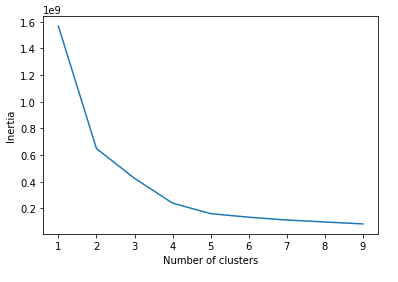

In [83]:
#From the plot, we can easily see that the ideal number of clusters is 2, so we apply it (it could be made the point that it was 4, but 2 seems the most relevant inflextion point)
model= TimeSeriesKMeans(n_clusters=2, n_init=5, max_iter=10, metric="dtw", random_state=22)
labels= model.fit_predict(df_value)

#We store in a dictionary the cluster label correspondet to each store
cluster_each_store_value=dict(zip(df_value.index.values, labels))

#Storing the previous dictionary in a CSV file
pd.DataFrame(cluster_each_store_value.values(), index=cluster_each_store_value.keys(), columns=["Label"]).to_csv("Store_value_labels.csv")

#### Exploring the results

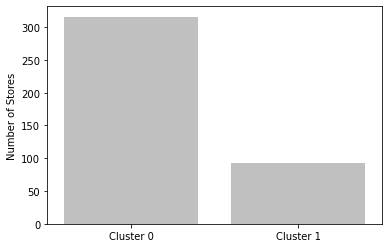

In [84]:
#Exploring the results of clustering by Value perspective

df_value["Store"]=df_value.index.values
df_value["Label"]=df_value.Store.apply(lambda x: cluster_each_store_value[x])
#Plotting the Distribution of the Number of Stores per Cluster
sns.barplot(y=pd.Series(cluster_each_store_value.values()).value_counts().values, x=pd.Series(cluster_each_store_value.values()).value_counts().index, palette=["grey", "steelblue"])
plt.xticks(ticks=[0,1],labels=["Cluster 0", "Cluster 1"])
plt.ylabel("Number of Stores")
plt.show()

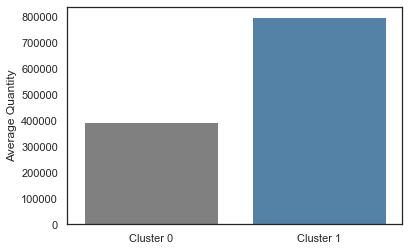

In [114]:
#finding the average quantity sold per store, for each cluster.
#Note that we used the 316 as it is the number od stores in cluster 0 and the 93, as it is the number of stores in cluster 1
average_value=(df_value.groupby("Label")[df_value.columns[:-1]].sum().sum(axis=1))/[316,93]

#plotting it
sns.barplot(y=average_value.values, x=[0,1], palette=["grey", "steelblue"])
plt.xticks(ticks=[0,1],labels=["Cluster 0", "Cluster 1"])
plt.ylabel("Average Quantity")
plt.show()

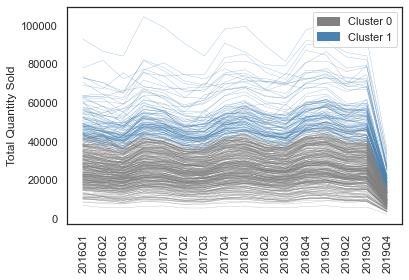

In [101]:
#Now, we will plot the time series correspondent to each Store, colored by the cluster each one belongs to

#Setting the line width as a low value, so we can more easily depict the lines
sns.set(style="white", rc={"lines.linewidth": 0.2})

#Getting the cluster label for each Store
df_value["Store"]=df_value.index.values
df_value["Label"]=df_value.Store.apply(lambda x: cluster_each_store_value[x])
df_value.drop("Store", axis=1, inplace=True)


#Plotting each time series with the correct color
for i in range(len(df_value)):
    label=df_value.iloc[i,:]["Label"]
    if label==0:
        color="grey"
    else:
        color="SteelBlue"
    sns.lineplot(y=df_value.iloc[i,:-1], x=[str(i) for i in df_value.columns[:-1]], color=color)

#Re-adjusting the layout
plt.xticks(rotation=90)
plt.ylabel("Total Quantity Sold")
grey_patch = mpatches.Patch(color='grey', label='Cluster 0')
blue_patch = mpatches.Patch(color='Steelblue', label='Cluster 1')
plt.legend(handles=[grey_patch, blue_patch], loc="upper right")

plt.show()

In [3]:
percentage_value_1 = df_value.groupby("Label")[df_value.columns[:-1]].sum().sum(axis=1)[1]/df_value.sum().sum()
percentage_stores_1 = pd.Series(cluster_each_store_value.values()).value_counts().values[1]/pd.Series(cluster_each_store_value.values()).value_counts().sum()

leverage_1 = percentage_value_1/percentage_stores_1


percentage_value_0 = df_value.groupby("Label")[df_value.columns[:-1]].sum().sum(axis=1)[0]/df_value.sum().sum()
percentage_stores_0 = pd.Series(cluster_each_store_value.values()).value_counts().values[0]/pd.Series(cluster_each_store_value.values()).value_counts().sum()

leverage_0 = percentage_value_0/percentage_stores_0

df_to_plot=pd.DataFrame(data={"Metric":["% Value", "% Stores", "% Value", "% Stores"], "Cluster":["Cluster 0", "Cluster 0", "Cluster 1", "Cluster 1"], "Values": [percentage_value_0, percentage_stores_0, percentage_value_1, percentage_stores_1]})

graph=sns.catplot( x="Metric", y="Values", col="Cluster", data=df_to_plot, kind="bar", aspect=.5,palette= ["silver", "lightblue"])

(graph.set_axis_labels("", "Percentage")
  .set_xticklabels(["", ""])
  .set_titles("{col_name} ")
  .set(ylim=(0, 1))
  .despine(left=True)) 

grey_patch = mpatches.Patch(color='silver', label='Quantity Sold')
blue_patch = mpatches.Patch(color='lightblue', label='Number Of Stores')
plt.legend(handles=[grey_patch, blue_patch], loc="upper right")
plt.show()

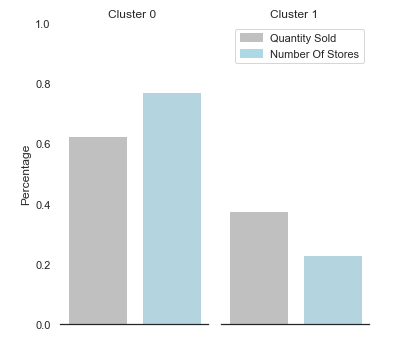

### K-Means DTW Preferences

Now, moving on to the the Perferences perspective, we will take a different approach.
In order to assess preferences, we will compute, for each Category, per store, the percentage of the total units sold in that quarter.
Then, recurring to these values, we will, for each Category, perform a cluster solution, using the TimeSeriesKMeans with the DTW metric.
When we have all the labels, for each store, for each category, we will recurr to KModes to cluster all the stores and get our final Preferences cluster solution.

In [115]:
#Importing the dataset at a quarter level
data_quarter=pd.read_csv('data_quarter.csv')

#Changing the Date's data type
data_quarter["Date"]=data_quarter["Date"].astype("datetime64")

#Converting each date into the respective Quarter
data_quarter["Date"] = pd.PeriodIndex((data_quarter.Date + pd.Timedelta(days=1)), freq='Q')


#We will perform our analysis by Category, and as such we create a dictionary to store the number of clusters for each cluster solution, per category.
nr_clusters_cat=dict(zip(data_quarter.Category.unique(), [0 for i in range(len(data_quarter.Category.unique()))]))


#Getting a dataframe with, for each store, per quarter, the percentage of quantity sold represented by each category
df=pd.pivot_table(data_quarter, columns="Category", index=["Store", "Date"], values="Quantity", aggfunc="sum").fillna(0)
percentage_df=(df.div(df.sum(axis=1), axis=0))
del df
percentage_df.head()

Category           1         2         3         4         5         6    \
Store Date                                                                 
1     2016Q1  0.010058  0.017569  0.040804  0.002547  0.000208  0.000572   
      2016Q2  0.007117  0.013728  0.031401  0.003065  0.000160  0.000426   
      2016Q3  0.005262  0.012938  0.016751  0.001678  0.000051  0.000458   
      2016Q4  0.009048  0.018295  0.040826  0.003514  0.000523  0.000498   
      2017Q1  0.010339  0.021677  0.046669  0.002789  0.000105  0.000053   

Category           7    8         9         10   ...       169       170  171  \
Store Date                                       ...                            
1     2016Q1  0.008551  0.0  0.001663  0.006679  ...  0.000000  0.000000  0.0   
      2016Q2  0.008103  0.0  0.002479  0.005278  ...  0.000160  0.000107  0.0   
      2016Q3  0.003457  0.0  0.001754  0.006406  ...  0.000407  0.000000  0.0   
      2016Q4  0.008275  0.0  0.001894  0.007826  ...  0.000000  0.000000  0.0   
      2017Q1  0.006419  0.0  0.003052  0.008182  ...  0.000053  0.000000  0.0   

Category      172       173  174       175  176  177       178  
Store Date                                                      
1     2016Q1  0.0  0.000052  0.0  0.078670  0.0  0.0  0.671960  
      2016Q2  0.0  0.000053  0.0  0.078875  0.0  0.0  0.703612  
      2016Q3  0.0  0.000203  0.0  0.077300  0.0  0.0  0.715735  
      2016Q4  0.0  0.000050  0.0  0.068667  0.0  0.0  0.660851  
      2017Q1  0.0  0.000079  0.0  0.060770  0.0  0.0  0.668420  

[5 rows x 178 columns]

#### Deciding Number of Cluster for K-Means DTW

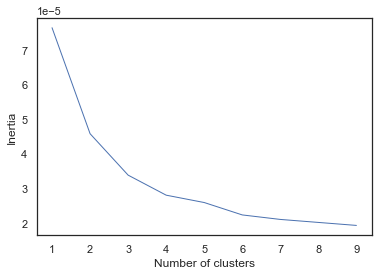

In [121]:
#In order to find the optimal number of clusters for each category (and thus for each cluster solution), we recurred to the plotting of the Inertia Plot.
#Note that we did this for each one of the 178 categories, and thus we only leave here the example for the Category 1. 
#The number of clusters was stored in the appropriate dictionary for each category.

#Defining the category in analysis
cat=1

#Getting a dataframe where the each row is a Store and each column is a Quarter. 
#The values correspond to the % of total units sold for this category, accordingly.
pref_df=percentage_df.unstack().iloc[:,percentage_df.unstack().columns.get_level_values("Category")==cat]
pref_df.columns=pref_df.columns.droplevel(0)

#Removing the Stores which never sold the category in question in this period.
pref_df=pref_df[(pref_df.max(axis=1)!=0)]


#Plotting the inertia plot
inertias=[]
for nr_clusters in range(1,10):
    model= TimeSeriesKMeans(n_clusters=nr_clusters, metric="dtw", n_init=5, max_iter=10, random_state=22)
    model.fit_predict(pref_df)
    inertias.append(model.inertia_)
    
plt.plot(pd.Series(inertias, index=np.arange(1,10)))
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.show()

In [118]:
# #After repeating this for the 178 categories, we save the dictionary as a CSV file
nr_clusters_df=pd.DataFrame(columns=["Category", "Nr_Clusters"])
nr_clusters_df["Category"]=nr_clusters_cat.keys()
nr_clusters_df["Nr_Clusters"]=nr_clusters_cat.values()
nr_clusters_df.to_csv("cat_nr_clusters.csv")

In [119]:
#Importing the CSV files necessary to "start" here
nr_clusters_df=pd.read_csv("cat_nr_clusters.csv").drop("Unnamed: 0", axis=1)
data_quarter=pd.read_csv('data_quarter.csv')
data_quarter["Date"]=data_quarter["Date"].astype("datetime64")
data_quarter["Date"] = pd.PeriodIndex((data_quarter.Date + pd.Timedelta(days=1)), freq='Q')

#Getting the same dataframe as we did previously
df=pd.pivot_table(data_quarter, columns="Category", index=["Store", "Date"], values="Quantity", aggfunc="sum").fillna(0)
percentage_df=(df.div(df.sum(axis=1), axis=0))
del df
#####

#Creating a dataframe to store the cluster labels given to each store, for each category
pref_clusters=pd.DataFrame(columns=data_quarter.Category.unique(), index=data_quarter.Store.unique()).sort_index()

#Going over the information stored in nr-clusters_df (category id and number of clusters), in order to find the cluster solution for each category.
for cat, nr_clusters in nr_clusters_df.values:

    #Getting a dataframe where the each row is a Store and each column is a Quarter. The values correspond to the % of total units sold for this category, accordingly.
    pref_df=percentage_df.unstack().iloc[:,percentage_df.unstack().columns.get_level_values("Category")==cat]
    pref_df.columns=pref_df.columns.droplevel(0)

    #Removing the Stores which never sold the category in question in this period.
    pref_df=pref_df[(pref_df.max(axis=1)!=0)]
    
    #Applying the model, with the appropriate number of clusters
    model= TimeSeriesKMeans(n_clusters=nr_clusters, metric="dtw", n_init=5, max_iter=10, random_state=22)
    model.fit_predict(pref_df)
    
    #storing in the dataframe, for the respective category, the labels obtained
    pref_clusters.loc[pref_df.index, cat]=model.labels_
    
#Filling the NaN values, which result from a store never selling a category in the period of analysis.
#We filled the missing values with the ext available label (e.g., if a cluster solution had 2 clusters, leading to labels 0 and 1, we filled them with 2)
for col in pref_clusters.columns:
    fill_col=pref_clusters[col].max()+1
    pref_clusters[col].fillna(fill_col, inplace=True)

### Applying K-Modes

#### Deciding Number of Clusters for K-Modes

In [131]:
#Now, we can apply the KModes to our pref_clusters dataframe.
#For this, we will start by recurring to the inertia plot to find the optimal number of clusters
sns.set(style="white", rc={"lines.linewidth": 2})
inertias=[]
for nr_clusters in range(1,10):
    model= KModes(n_clusters=nr_clusters, init = "Huang", n_init = 10, random_state=22)
    labels= model.fit_predict(pref_clusters)
    inertias.append(model.cost_)
    
plt.plot(pd.Series(inertias, index=np.arange(1,10)))
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.show()

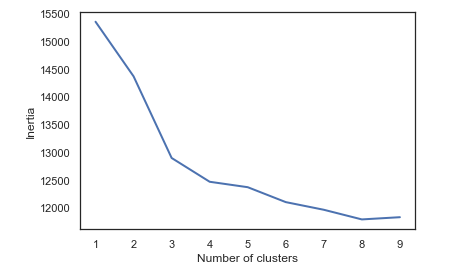

In [132]:
#From the graph, one can see that we should proceed with 3 clusters.
model= KModes(n_clusters=3, init = "Huang", n_init = 10, random_state=22)
labels=model.fit_predict(pref_clusters)

#For each store, getting the correspondent cluster label
cluster_each_store=dict(zip(pref_clusters.index.values, labels))

#Storing the results in a CSV
pd.DataFrame(cluster_each_store.values(), index=cluster_each_store.keys(), columns=["Label"]).to_csv("Store_labels.csv")

#### Exploring the results

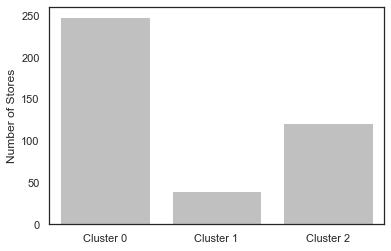

In [133]:
#Distribution of the Number of Stores per Cluster
sns.barplot(y=pd.Series(cluster_each_store.values()).value_counts().values, x=pd.Series(cluster_each_store.values()).value_counts().index, palette=["silver", "silver", "silver"])
plt.xticks(ticks=[0,1,2],labels=["Cluster 0", "Cluster 1", "Cluster 2"])
plt.ylabel("Number of Stores")
plt.show()

In [135]:
def top_products_per_cluster(hierar):
    """This function receives as input a Product Level Hierarchy (e.g., Name, Brand, Category, Family) and, for each cluster 
    found previoulsy, returns the top 5 products most sold in the period in analysis."""
    
    #Grouping the data regardless of the Date
    data_grouped=data_quarter.groupby(["Store", "Family", "Category", "Brand", "Name"])["Quantity"].sum().reset_index()

    #Getting the right cluster label for each cluster
    data_grouped["Label"]=data_grouped["Store"].apply(lambda x: cluster_each_store[x])

    #Getting the total values per cluster, according to the Hierarchy level chosen
    top_per_cluster=data_grouped.groupby(["Label", hierar])["Quantity"].sum().unstack().T
    
    #Getting the number of stores per cluster
    nr_per_cluster=pd.Series(cluster_each_store.values()).value_counts().to_dict()
    
    #Computing the means per cluster, dividing the total quantities by the number of stores per cluster
    top_per_cluster[0]=top_per_cluster[0]/nr_per_cluster[0]
    top_per_cluster[1]=top_per_cluster[1]/nr_per_cluster[1]
    top_per_cluster[2]=top_per_cluster[2]/nr_per_cluster[2]
    
    
    #Finding the 5 products most sold, for each cluster
    cluster_0_values=dict(zip(top_per_cluster.sort_values(0, ascending=False).head(5).iloc[:,0].index.values, [round(i,2) for i in top_per_cluster.sort_values(0, ascending=False).head(5).iloc[:,0].values]))
    cluster_1_values=dict(zip(top_per_cluster.sort_values(1, ascending=False).head(5).iloc[:,1].index.values, [round(i,2) for i in top_per_cluster.sort_values(1, ascending=False).head(5).iloc[:,1].values]))
    cluster_2_values=dict(zip(top_per_cluster.sort_values(2, ascending=False).head(5).iloc[:,2].index.values, [round(i,2) for i in top_per_cluster.sort_values(2, ascending=False).head(5).iloc[:,2].values]))
  
    
    #Creating the figure
    fig = make_subplots(
    rows=1,
    cols=3,
    shared_xaxes=True,
    horizontal_spacing=0.03,
    specs=[[{"type": "table"},{"type": "table"}, {"type": "table"}]],
    subplot_titles=("Cluster 0", "Cluster 1", "Cluster 2")
    )

    #Adding the respective tables
    fig.add_trace(
        go.Table(
            header=dict(values=["Product "+str(hierar), "Average Units"],
                font=dict(size=13),
                align="center"
            ),
            cells=dict(
                values=[list(cluster_0_values.keys()), list(cluster_0_values.values())],
                align = "center")
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Table(
            header=dict(values=["Product "+str(hierar), "Average Units"],
                font=dict(size=13),
                align="center"
            ),
            cells=dict(
                values=[list(cluster_1_values.keys()), list(cluster_1_values.values())],
                align = "center")
        ),
        row=1, col=2
    )

    
    fig.add_trace(
        go.Table(
            header=dict(values=["Product "+str(hierar), "Average Units"],
                font=dict(size=13),
                align="center"
            ),
            cells=dict(
                values=[list(cluster_2_values.keys()), list(cluster_2_values.values())],
                align = "center")
        ),
        row=1, col=3
    )
    
    #Updating the layout
    fig.update_layout(height=350, width=800,
                      title_text="Top 5 Product "+str(hierar)+ " sold, per Cluster")

    return go.Figure(fig)

In [1]:
#Applying the function to get the Top 5 products sold, per Name, per cluster. 
#One can see that there are indeed differences in preferences between clusters.
top_products_per_cluster("Name")

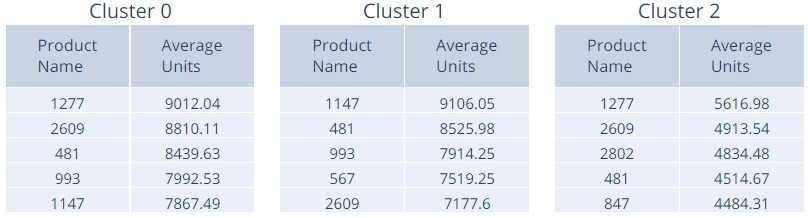

# Forecast per product per store

### Preparing data for the forecast: Remove non-sold items

In [125]:
#Importing the data at a week level
data_forecast = pd.read_csv("data.csv")

In [126]:
#Importing the dataset where we stored the products which we saw previously that weren't sold anymore
remove = pd.read_csv("remove_forecast.csv")

In [127]:
#Removing the Names, Categories and Brands
data_forecast= data_forecast[~np.in1d(data_forecast["Name"], list(remove["Name"]))]
data_forecast= data_forecast[~np.in1d(data_forecast["Category"], list(remove["Category"]))]
data_forecast= data_forecast[~np.in1d(data_forecast["Brand"], list(remove["Brand"]))]

In [128]:
#saving the dataset at a weekly level, ready to be used to forecast
data_forecast.to_csv("data_forecast.csv")

### XGBOOST

#### Train and Test Split

In [61]:
#We will start by applying the XGBoost model to our problem.
#In the first place, we have to generate a train set, where we have all the combinations verified in the train set: we want, for all weeks, for each store, for each product Name sold by them (independently of the week).
#Note that we have to do this, because if a store sold product X in a certain week, and not in the others, we have to take that into consideration, in order for the model to know that in the remaining weeks, the amount sold was 0 units, for that store.
#Then, we would have to do the same for the test set, by considering the products bought in the train set.

#Starting by getting all the combinations for the train set:

#Due to the size of the dataset which contains the data at a week level, we will take advatnge of the data poer quarter to get the combinations until the maximum date we can, and then we combine those findings with the data at a weekly level, to get possible remaining combinations in the weeks still left for the train set.
#Importing the dataset at a quarter level and doing the usual changes in it, plus removing all the products which we saw were not solved anymore. 
data_quarter=pd.read_csv('data_quarter.csv').drop("Unnamed: 0", axis=1)
data_quarter["Date"]=data_quarter["Date"].astype("datetime64")

remove = pd.read_csv("remove_forecast.csv")
data_quarter= data_quarter[~np.in1d(data_quarter["Name"], list(remove["Name"]))]
data_quarter= data_quarter[~np.in1d(data_quarter["Category"], list(remove["Category"]))]
data_quarter= data_quarter[~np.in1d(data_quarter["Brand"], list(remove["Brand"]))]

#Selecting only the data from the quarters which we considered to be in the train set
data_quarter=data_quarter[data_quarter["Date"]<np.datetime64("2019-06-28")]


#Importing now the data at a weekly level (from which we don't need to remove any products, as it was already done previously)
data_weekly=pd.read_csv("data_forecast.csv").drop("Unnamed: 0", axis=1)
data_weekly["Date"]=data_weekly["Date"].astype("datetime64")

#Considering our test set are the last 6 weeks we have of data (until 16-09-2019, inclusive), we will now select only the weeks which are missing from the previous selection we made from the data at a quarter level
data_weekly=data_weekly[data_weekly["Date"]<np.datetime64("2019-09-23")]
data_weekly=data_weekly[data_weekly["Date"]>np.datetime64("2019-06-01")]

#Joining the datasets into one
data_weekly=data_quarter[["Name","Store", "Date"]].append(data_weekly[["Name","Store", "Date"]], ignore_index=True)


def get_combinations_df (store):
    """This function receives a store id (integer), and retruns a dataset with all the products sold by it and all the weeks'
    start dates, from 28-12-2015 to 16-09-2019, both inclusive"""
    
    #Checking, for the store provided, all the products bought
    prods_bought=data_weekly[data_weekly.Store==store]["Name"].unique()
    
    #Defining the train set dates, weekly
    dates=pd.date_range(start="2015-12-28",end="2019-09-16", freq="W-MON")
    
    #Defining a dataframe with all the combinations, recurring to "product"
    df=pd.DataFrame(columns=["Store", "Date", "Name"])
    comb=list(product([store], dates, prods_bought))
    df=pd.DataFrame(comb, columns=["Store", "Date", "Name"])
    
    return df

#Applying the function to all the stores we have, getting this way, all the combinations
get_all_comb=list(map(get_combinations_df, data_weekly.Store.unique()))

#Joining all the results obtained into a single dataframe
comb_train=pd.DataFrame(columns=["Store", "Date", "Name"])

for df in get_all_comb:
    comb_train=comb_train.append(df)

comb_train.reset_index(drop=True, inplace=True)

#Saving it to a CSV
comb_train.to_csv("all_combinations_train_df.csv")

In [62]:
#Moving now to the test set, we will start by importing the dataset we just created
test_set=pd.read_csv("all_combinations_train_df.csv").drop("Unnamed: 0", axis=1)

#We have to define the dates we want to have in our test dataset
dates_test=pd.date_range(start="2019-09-23",end="2019-10-28", freq="W-MON")

#We select the dates in the train set
dates_to_replace=sorted(list(test_set.Date.unique()))

#Now, instead of repeating all we did for the train set, as we have already all the right combinations in the dataset we just imported,and the only problem is with the dates, we will select the first 5 dates in the train set and replace them with the ones from the test set.
test_set["Date"]=test_set["Date"].apply(lambda x: dates_test[0] if x== dates_to_replace[0] else dates_test[1] if x== dates_to_replace[1] else dates_test[2] if x== dates_to_replace[2] else dates_test[3] if x== dates_to_replace[3] else dates_test[4] if x== dates_to_replace[4] else dates_test[5] if x== dates_to_replace[5] else x)

#Then, we can just delete all the entries whose date is before the first one from the test set and we have already the dataset ready
test_set=test_set[test_set["Date"]>=np.datetime64("2019-09-23")]

#Saving it to CSV
test_set.to_csv("all_combinations_test_df.csv")

In [63]:
#Now, we can move one to the XGBoost itself

#Importing the datasets we created for train and test
train_set=pd.read_csv("all_combinations_train_df.csv").drop("Unnamed: 0", axis=1)
test_set=pd.read_csv("all_combinations_test_df.csv").drop("Unnamed: 0", axis=1)

train_set["Date"] =train_set["Date"].astype("datetime64")
test_set["Date"] =test_set["Date"].astype("datetime64")

In [64]:
#Importing the dataset with the data per week and dropping the columns which are useless for our problem
data_forecast=pd.read_csv("data_forecast.csv").drop(["Unnamed: 0", "Family", "Category", "Brand", "Value"], axis=1)
data_forecast["Date"] = data_forecast["Date"].astype("datetime64")

#Grouping the data, because a Name can be part of more than 1 Category, for instance, and therefore there's the need to compute the total units.
data_forecast = data_forecast.groupby(["Date", "Name", "Store"])["Quantity"].sum().reset_index()

#Selecting only the data for the train set
data_forecast = data_forecast[data_forecast.Date<np.datetime64("2019-09-23")]

#Merging this dataset with the one we imported/created previously, with all the combinations
train_set = train_set.merge(data_forecast, how="outer", left_on=["Date", "Store", "Name"], right_on=["Date", "Store", "Name"])

#Replacing the NaN with zeros, as it means no quantity was sold
train_set["Quantity"]= train_set["Quantity"].fillna(0)

#Creating variables to feed to the model: Number of the Week in the Year, the Month and the Year
train_set["WeekNumber"]=train_set["Date"].apply(lambda x: x.isocalendar()[1])
train_set["Month"]=train_set["Date"].apply(lambda x: x.month)
train_set["Year"]=train_set["Date"].apply(lambda x: x.year)

#We drop the Date, because its information is already stored in the created variables
train_set.drop("Date", inplace= True, axis=1)

In [65]:
#Now, we will repeat the process for the test set
data_forecast=pd.read_csv("data_forecast.csv").drop(["Unnamed: 0", "Family", "Category", "Brand", "Value"], axis=1)
data_forecast["Date"] = data_forecast["Date"].astype("datetime64")
data_forecast = data_forecast.groupby(["Date", "Name", "Store"])["Quantity"].sum().reset_index()
data_forecast = data_forecast[data_forecast.Date>=np.datetime64("2019-09-23")]

In [66]:
#Merging the data_forecast with the test_set, with all combinations
test_set = test_set.merge(data_forecast, how="left", left_on=["Date", "Store", "Name"], right_on=["Date", "Store", "Name"])

#Replacing NaNs with zeros
test_set["Quantity"]= test_set["Quantity"].fillna(0)

#Creating the same variables
test_set["WeekNumber"]=test_set["Date"].apply(lambda x: x.isocalendar()[1])
test_set["Month"]=test_set["Date"].apply(lambda x: x.month)
test_set["Year"]=test_set["Date"].apply(lambda x: x.year)

test_set.drop("Date", inplace= True, axis=1)

In [67]:
#Saving the datasets ready to feed to the model into CSVs
train_set.to_csv("trainxgb.csv")
test_set.to_csv("testxgb.csv")

#### Applying the model

In [70]:
#Importing the train and test sets for the XGBoost model
train_set = pd.read_csv("trainxgb.csv").drop("Unnamed: 0", axis=1)
test_set = pd.read_csv("testxgb.csv").drop("Unnamed: 0", axis=1)

In [54]:
#Applying the XGBRegressor for different combinations and storing the results, in order to find the best parameters

results_xgb=pd.DataFrame(columns=["RMSE"])

for learning_r in [0.5, 0.1]:
    LR=learning_r
    for max_d in [10,15]:
        MD=max_d
        for n_est in [100]:
            N_EST=n_est
            
            model=XGBRegressor(n_jobs=-1, random_state=22, n_estimators =N_EST, learning_rate=LR, max_depth=MD)
            model.fit(train_set.drop("Quantity", axis=1), train_set["Quantity"])
            
            #Amount predicted by the model. Note we replaced all negative values by 0, as it makes no sense for the context to predict negative quantities. Then, we rounded the predictions to integers, because it also doesn't make sense to predict to sell X.X units.
            quant_pred= pd.Series(model.predict(test_set.drop("Quantity", axis=1))).apply(lambda x: 0 if x<0 else x).round()
            
            #computing the RMSE value
            error=mean_squared_error(test_set["Quantity"], quant_pred, squared=False)
            
            #Storing the results into a dataframe
            results_xgb.loc["Learning_rate "+str(LR)+", Max_Depth "+str(MD)+", Nr_Estimators "+str(N_EST) , "RMSE"]=error

#Sorting by RMSE and saving the results to a CSV
results_xgb.sort_values("RMSE")       
results_xgb.to_csv("results_xgb.csv")
results_xgb.head()

In [55]:
#Importing the results
results = pd.read_csv("results_xgb.csv")

In [60]:
#checking the results
results

Unnamed: 0      RMSE
0  Learning_rate 0.5, Max_Depth 10, Nr_Estimators...  6.864878
1  Learning_rate 0.5, Max_Depth 15, Nr_Estimators...  6.866180
2  Learning_rate 0.1, Max_Depth 10, Nr_Estimators...  6.868493
3  Learning_rate 0.1, Max_Depth 15, Nr_Estimators...  6.864643

### SARIMAX

Now, we will apply the SARIMAX model. Our approach was the following:

We started by applying a KShape cluster algorithm, in order to group the combination of Store and Name product according to the shape of their time series during the period in study in the train set. This way, we can have the combinations of Stores and Name grouped by similiar patterns. Once this is done, we can get the best SARIMAX model for each cluster and then apply it to each store contained in the specific cluster, which allows this model to be used relatively quickly and efficiently (considering we are dealing with weekly predictions, if we were to do it every week, we needed a model faily fast to run).

In [2]:
#Importing the dataset with data at a weekly level
data_forecast = pd.read_csv("data_forecast.csv")
data_forecast["Date"]=data_forecast["Date"].astype("datetime64")

In [3]:
#Due to the reasons explained before, we have to compute the "real" amount sold by Name
data_forecast = data_forecast.groupby(["Name","Store", "Date"])["Quantity"].sum().reset_index()

In [4]:
#Splitting the data into train and test sets
data_forecast_train=data_forecast[data_forecast["Date"]<np.datetime64("2019-09-23")]
data_forecast_test=data_forecast[data_forecast["Date"]>=np.datetime64("2019-09-23")]

#Putting the data in the right format for this analysis and replacing the NaNs with zeros
data_forecast_train = pd.pivot_table(data=data_forecast_train, index=["Store", "Name"], columns="Date", values="Quantity", aggfunc="sum")
data_forecast_train = data_forecast_train.fillna(0)

In [56]:
#Applying the KShape algorithm to, through a Inertia plot, find the optimal number of clusters for our stores
inertias=[]
for nr_clusters in range(1,10):
    model= KShape(n_clusters=nr_clusters, max_iter=10, random_state=22)
    labels= model.fit_predict(data_forecast_train)
    inertias.append(model.inertia_)
    
plt.plot(pd.Series(inertias, index=np.arange(1,10)))
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.show()

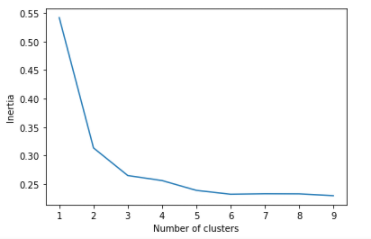

In [7]:
#The elbow is between 2 or 3 clusters, being that we chose 3 as the number to proceed, as it allows for more diversity.
model= KShape(n_clusters=3, max_iter=10, random_state=22)
data_forecast_train["labels"]= model.fit_predict(data_forecast_train)

In [8]:
#Splittig the train set into 3 different ones, each referent to a specific cluster and storing the stores and names combinations for each

data_forecast_train = data_forecast_train.reset_index()
clusters = ["cluster0", "cluster1", "cluster2"]

for i in range(3):
    data_cluster = data_forecast_train[data_forecast_train["labels"]==i]
    locals()[clusters[i]] =data_cluster[["Store", "Name"]].values.tolist()

In [9]:
#Storing the centroids of each cluster
centroid0 = [item for sublist in model.cluster_centers_[0] for item in sublist]
centroid1 = [item for sublist in model.cluster_centers_[1] for item in sublist]
centroid2 = [item for sublist in model.cluster_centers_[2] for item in sublist]

As we are only going to find the best SARIMAX for the centroids shape, we will rely on automatic methods, as it tends to give good results, makes all the tests needed by itself, and being only to a limited number of centroids, we can do it this way.

<AxesSubplot:>

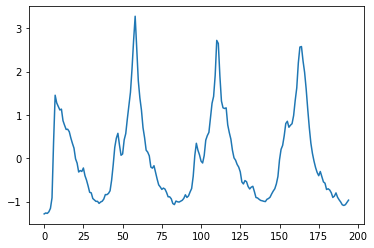

In [12]:
#Plotting the centroids for the CLuster 0.
#Please note that for this graph (and all the remaining on the notebook concerning the plotting of the centroid for this purpose), the values in the y-axis (even when negative) have no meaning, what is of interest is the shape obtained.
pd.Series(centroid0).plot()

In [15]:
#Using the centroids, we use the auto_arima to find the best parameters for the SARIMAX model
centroid0 = pd.DataFrame(list(zip(data_forecast_train.columns.values[2:-1], centroid0 ))).set_index(0)
centroidt = auto_arima(centroid0)
centroidt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(1, 0, 2)   Log Likelihood                  49.708
Date:                Wed, 26 May 2021   AIC                            -91.415
Time:                        13:15:51   BIC                            -78.323
Sample:                             0   HQIC                           -86.114
                                - 195                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9185      0.020     45.889      0.000       0.879       0.958
ma.L1          0.8797      0.059     14.852      0.000       0.764       0.996
ma.L2          0.3390      0.055      6.173      0.000       0.231       0.447
sigma2         0.0344      0.002     19.502      0.000       0.031       0.038
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               583.79
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

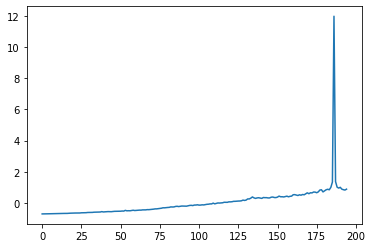

In [13]:
#Plotting the centroids for the cluster 1
pd.Series(centroid1).plot()

In [16]:
#Using the centroids, we use the auto_arima to find the best parameters for the SARIMAX model
centroid1 = pd.DataFrame(list(zip(data_forecast_train.columns.values[2:-1], centroid1 ))).set_index(0)
centroid1 = auto_arima(centroid1)
centroid1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -234.892
Date:                Wed, 26 May 2021   AIC                            475.785
Time:                        13:16:09   BIC                            485.588
Sample:                             0   HQIC                           479.754
                                - 195                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0113      0.033      0.338      0.736      -0.054       0.077
ma.L1         -0.9494      0.090    -10.547      0.000      -1.126      -0.773
sigma2         0.6516      0.071      9.117      0.000       0.512       0.792
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):            274595.97
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):             202.82   Skew:                            13.45
Prob(H) (two-sided):                  0.00   Kurtosis:                       185.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

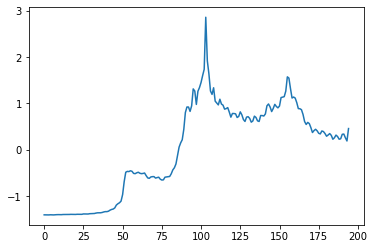

In [17]:
#Plotting the centroids of the cluster 2
pd.Series(centroid2).plot()

In [18]:
#Using the centroids, we use the auto_arima to find the best parameters for the SARIMAX model
centroid2 = pd.DataFrame(list(zip(data_forecast_train.columns.values[2:-1], centroid2 ))).set_index(0)
centroid2 = auto_arima(centroid2)
centroid2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(5, 1, 2)   Log Likelihood                 122.639
Date:                Wed, 26 May 2021   AIC                           -229.277
Time:                        13:16:29   BIC                           -203.134
Sample:                             0   HQIC                          -218.691
                                - 195                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5640      0.061     -9.245      0.000      -0.684      -0.444
ar.L2         -0.5515      0.084     -6.552      0.000      -0.717      -0.387
ar.L3         -0.0786      0.050     -1.567      0.117      -0.177       0.020
ar.L4          0.0725      0.080      0.907      0.364      -0.084       0.229
ar.L5          0.3143      0.047      6.657      0.000       0.222       0.407
ma.L1          0.6032      0.077      7.805      0.000       0.452       0.755
ma.L2          0.6650      0.090      7.402      0.000       0.489       0.841
sigma2         0.0164      0.001     18.823      0.000       0.015       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3853.13
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.53   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
#Re-arranging our dataset, in order to be in the right format to be fed to the model
data_forecast_train = data_forecast_train.melt(value_vars=data_forecast_train.columns[2:-1], id_vars=["Store", "Name", "labels"])

In [11]:
#Selecting the dataset correspondent to each label 
cluster_0 = data_forecast_train[data_forecast_train["labels"]==0]
cluster_1 = data_forecast_train[data_forecast_train["labels"]==1]
cluster_2 = data_forecast_train[data_forecast_train["labels"]==2]

In [28]:
#Please note the following functions follow always the same rational, one for each cluster and as such we will not comment all of them, just the ones for the cluster 0.

def find_series_sarima_cluster0 (store):
    """This function receives a Store ID (integer) and returns a list of dataframes.
    Each dataframe has as columns 'Date', 'value', 'Name', 'Store', and although the Store ID is always the same as the one 
    passed to the function, the Name will change according to the combinations found in train set.
    This function is specific for the cluster 0, meaning it will get all combinations of products bought by the store in question
    found in the cluster_0 dataframe."""
    
    #Slicing the cluster_0 dataframe to have only the store in question
    sliced=cluster_0[cluster_0.Store==store]
    
    #finding the products bought
    prods=list(sliced.Name.unique())
    prods.sort()
    
    #to store the series to return at the end
    series=[]
    
    #for each product, store the serie in the series list
    for prod in prods:
        serie=pd.DataFrame()
        serie["Date"]=sliced[sliced.Name==prod].Date
        serie["value"]=sliced[sliced.Name==prod].value
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        serie=serie.set_index("Date")
        series.append(serie)
    
    return series

def find_series_sarima_cluster1 (store):
    """This function receives a Store ID (integer) and returns a list of dataframes.
    Each dataframe has as columns 'Date', 'value', 'Name', 'Store', and although the Store ID is always the same as the one 
    passed to the function, the Name will change according to the combinations found in train set.
    This function is specific for the cluster 1, meaning it will get all combinations of products bought by the store in question
    found in the cluster_1 dataframe."""
    
    sliced=cluster_1[cluster_1.Store==store]
    prods=list(sliced.Name.unique())
    prods.sort()
    series=[]
    for prod in prods:
        serie=pd.DataFrame()
        serie["Date"]=sliced[sliced.Name==prod].Date
        serie["value"]=sliced[sliced.Name==prod].value
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        serie=serie.set_index("Date")
        series.append(serie)
    
    return series

def find_series_sarima_cluster2 (store):
    """This function receives a Store ID (integer) and returns a list of dataframes.
    Each dataframe has as columns 'Date', 'value', 'Name', 'Store', and although the Store ID is always the same as the one 
    passed to the function, the Name will change according to the combinations found in train set.
    This function is specific for the cluster 2, meaning it will get all combinations of products bought by the store in question
    found in the cluster_2 dataframe."""
    
    sliced=cluster_2[cluster_2.Store==store]
    prods=list(sliced.Name.unique())
    prods.sort()
    series=[]
    for prod in prods:
        serie=pd.DataFrame()
        serie["Date"]=sliced[sliced.Name==prod].Date
        serie["value"]=sliced[sliced.Name==prod].value
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        serie=serie.set_index("Date")
        series.append(serie)
    
    return series



def run_sarima_cluster0(timeserie_complete):
    """This function receives a time series in the format of a dataframe, with columns 'Date', 'value', 'Name' and 'Store'.
    Applying a SARIMAX model with the parameters appropriate to the cluster 0, the function returns a dataframe with
    the predictions for the period of test, with columns 'Name', 'Store', 'Date' and 'predicted_mean'. """
    #We have to import all librabries needed, here, because when running in parallel, the librabries have to be imported inside the function being used
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    
    #Taking out the Name and Store from the time serie, as this information is not required by the model, but storing the Name and Store, appropriately
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    
    #####################################################
    
    #Applying the model with the previously found parameters
    model = sm.tsa.statespace.SARIMAX(timeserie, trend=None, order=(1,0,2), initialization='approximate_diffuse').fit()
    
    #Predicting for the test set dates
    pred = model.predict(np.datetime64("2019-09-23"),np.datetime64("2019-10-28"))
    
    #Storing the results in a dataframe to return
    pred=pd.DataFrame(pred)
    pred["Name"]=[name for i in range(len(pred))]
    pred["Store"]=[POS for i in range(len(pred))]
    pred["Date"]=[np.datetime64("2019-09-23"), np.datetime64("2019-09-30"), np.datetime64("2019-10-07"), np.datetime64("2019-10-14"), np.datetime64("2019-10-21"), np.datetime64("2019-10-28")]
    
    return pred

def run_sarima_cluster1(timeserie_complete):
        """This function receives a time series in the format of a dataframe, with columns 'Date', 'value', 'Name' and 'Store'.
    Applying a SARIMAX model with the parameters appropriate to the cluster 1, the function returns a dataframe with
    the predictions for the period of test, with columns 'Name', 'Store', 'Date' and 'predicted_mean'. """
    
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    
    #####################################################
    
    model = sm.tsa.statespace.SARIMAX(timeserie, trend="c", order=(0,1,1), initialization='approximate_diffuse').fit()
    pred = model.predict(np.datetime64("2019-09-23"),np.datetime64("2019-10-28"))
    pred=pd.DataFrame(pred)
    pred["Name"]=[name for i in range(len(pred))]
    pred["Store"]=[POS for i in range(len(pred))]
    pred["Date"]=[np.datetime64("2019-09-23"), np.datetime64("2019-09-30"), np.datetime64("2019-10-07"), np.datetime64("2019-10-14"), np.datetime64("2019-10-21"), np.datetime64("2019-10-28")]
    
    return pred

def run_sarima_cluster2(timeserie_complete):
        """This function receives a time series in the format of a dataframe, with columns 'Date', 'value', 'Name' and 'Store'.
    Applying a SARIMAX model with the parameters appropriate to the cluster 2, the function returns a dataframe with
    the predictions for the period of test, with columns 'Name', 'Store', 'Date' and 'predicted_mean'. """
        
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    
    #####################################################
  
    model = sm.tsa.statespace.SARIMAX(timeserie , order=(5,1,2), initialization='approximate_diffuse').fit()
    pred = model.predict(np.datetime64("2019-09-23"),np.datetime64("2019-10-28"))
    pred=pd.DataFrame(pred)
    pred["Name"]=[name for i in range(len(pred))]
    pred["Store"]=[POS for i in range(len(pred))]
    pred["Date"]=[np.datetime64("2019-09-23"), np.datetime64("2019-09-30"), np.datetime64("2019-10-07"), np.datetime64("2019-10-14"), np.datetime64("2019-10-21"), np.datetime64("2019-10-28")]
    
    return pred

In [29]:
#Again, we will comment the code for the case of the cluster 0 only, we the remaining is the same, only adapted to the clusters 1 and 2

#creating a clist to store the predictions for the cluster
predictions_0=[]

#for each store present in the cluster 0
for store in cluster_0.Store.unique():
    #Initiallizing the necessary to run our functions in parallel
    p = mp.Pool(cpu_count())
    
    #using our function to find the time series for this cluster
    series_to_run=find_series_sarima_cluster0(store)
    
    #in parallel, using p.imap, we apply the function run_sarima_cluster_0 to each serie found
    predictions_0.append(list(p.imap(run_sarima_cluster0, series_to_run )))
    p.close()
    p.join()

#creating the dataframe to store the predictions
preds_cluster_0=pd.DataFrame(columns=["predicted_mean", "Name", "Store", "Date"])

#Joining everything in the same dataframe and saving it to CSV
for df in predictions_0:
    preds_cluster_0=preds_cluster_0.append(df)
    
preds_cluster_0.reset_index(drop=True, inplace=True)
preds_cluster_0.to_csv("train_00_sarima.csv")



#For cluster 1
predictions_1=[]

for store in cluster_1.Store.unique():
    p = mp.Pool(cpu_count())
    series_to_run=find_series_sarima_cluster1(store)
    predictions_1.append(list(p.imap(run_sarima_cluster1, series_to_run )))
    p.close()
    p.join()
    
preds_cluster_1=pd.DataFrame(columns=["predicted_mean", "Name", "Store", "Date"])
for df in predictions_1:
    preds_cluster_1=preds_cluster_1.append(df)
    
preds_cluster_1.reset_index(drop=True, inplace=True)
preds_cluster_1.to_csv("train_11_sarima.csv")



#For cluster 2
predictions_2=[]

for store in cluster_2.Store.unique():
    p = mp.Pool(cpu_count())
    series_to_run=find_series_sarima_cluster2(store)
    predictions_2.append(list(p.imap(run_sarima_cluster2, series_to_run )))
    p.close()
    p.join()
    
preds_cluster_2=pd.DataFrame(columns=["predicted_mean", "Name", "Store", "Date"])
for df in predictions_2:
    preds_cluster_2=preds_cluster_2.append(df)
    
preds_cluster_2.reset_index(drop=True, inplace=True)
preds_cluster_2.to_csv("train_22_sarima.csv")

In [30]:
#Importing the predictions from each cluster
zero = pd.read_csv("train_00_sarima.csv").drop("Unnamed: 0", axis=1)
one= pd.read_csv("train_11_sarima.csv").drop("Unnamed: 0", axis=1)
two= pd.read_csv("train_22_sarima.csv").drop("Unnamed: 0", axis=1)

In [31]:
#Joining all predictions into one dataframe
predict = zero.append(one, ignore_index= True).append(two, ignore_index= True)

#Making sure that the negative values are considered as zeros and that we only have integer values
predict["predicted_mean"] = predict["predicted_mean"].apply(lambda x: 0 if x<0 else x).round()

#Setting the Date as satetime
predict["Date"] = predict["Date"].astype("Datetime64")

#getting the real quantities, in order to find how good was our model
forecast_comparation = predict.merge(data_forecast_test, how = "left", left_on =["Name", "Date", "Store"], right_on =["Name", "Date", "Store"])
forecast_comparation["Quantity"] = forecast_comparation["Quantity"].fillna(0)

In [32]:
#Computing the RMSE error
mean_squared_error(forecast_comparation["Quantity"], forecast_comparation["predicted_mean"], squared=False)

3.126487423268798

In [69]:
#Seeing, on average, by how many units we were failed our predictions. We can see that the real Quantity is usually higher than the one we predict, but not but a significant amount.
(forecast_comparation["predicted_mean"]-forecast_comparation["Quantity"]).sum()/(len(forecast_comparation["Quantity"]))

-0.041823354721700526

### Propheth

In [45]:
#Importing the dataset at a weekly level
data_forecast = pd.read_csv("data_forecast.csv")
data_forecast["Date"]=data_forecast["Date"].astype("datetime64")

In [46]:
#Getting the "real" quantities for the Name level
data_forecast = data_forecast.groupby(["Name","Store", "Date"])["Quantity"].sum().reset_index()

#### Train and Test Split

In [47]:
#Splitting the data into train and test sets
data_forecast_train=data_forecast[data_forecast["Date"]<np.datetime64("2019-09-23")]
data_forecast_test=data_forecast[data_forecast["Date"]>=np.datetime64("2019-09-23")]

#### Applying the model

In [68]:
def find_series (store):
    """This function receives as input the ID of a store and returns a list with a timeseries per product Name sold by that
    store in the priod in question."""
    
    #Slicing the dataframe to only have data for the Store at hand
    sliced=data_forecast_train[data_forecast_train.Store==store]
    
    #Finding the products sold by the store
    prods=list(sliced.Name.unique())
    prods.sort()
    
    #storing the in series list a dataframe with columns 'ds' (date), 'y' (amount sold), 'Name' and 'Store'
    series=[]
    for prod in prods:
        serie=pd.DataFrame(columns=["ds", "y"])
        serie["ds"]=sliced[sliced.Name==prod].Date
        serie["y"]=sliced[sliced.Name==prod].Quantity
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        series.append(serie)
    return series

def run_prophet(timeserie_complete):
    """This function receives as input a timeseries in a dataframe, with columns 'ds', 'y', 'Name' and 'Store'.
    The timeseries is fed to the model Prophet, returning a dataframe with the predictions to the test set period, with 
    columns 'ds', 'yhat', 'Name' and 'Store'."""
    
    #Once more, as explained, we need to have the librabries imported here
    from fbprophet import Prophet
    import pandas as pd
    import numpy as np
    
    #Slicing the timeserie to have only the oclumns required by the model, but storing the store and name
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    
    #####################################################
    
    #Creating the model
    model = Prophet(uncertainty_samples=0, yearly_seasonality="auto" ,weekly_seasonality="auto", daily_seasonality=False).add_seasonality(name="quarterly", period =365.25/4, fourier_order =5, prior_scale = 15)
    
    #In case the product was sold less than 2 times in the train period, then it can not be predicted by the model, and thus we have to manually predict for all dates, as 0
    if len(timeserie)<2:
        forecast=pd.DataFrame(columns=["ds", "yhat"])
        forecast["ds"]=[np.datetime64("2019-09-23"), np.datetime64("2019-09-30"), np.datetime64("2019-10-07"), np.datetime64("2019-10-14"), np.datetime64("2019-10-21"), np.datetime64("2019-10-28")]
        forecast["yhat"]=[0 for i in range(len(forecast))]
        forecast["Name"]=[name for i in range(len(forecast))]
        forecast["Store"]=[POS for i in range(len(forecast))]
    
    #Otherwise, we fit to the model and use it to predict
    else:
        model.fit(timeserie)
        
        #Predicting and re-defining the output
        df_test=pd.DataFrame(columns=["ds"])
        df_test["ds"]=[np.datetime64("2019-09-23"), np.datetime64("2019-09-30"), np.datetime64("2019-10-07"), np.datetime64("2019-10-14"), np.datetime64("2019-10-21"), np.datetime64("2019-10-28")]
        forecast = model.predict(df_test)
        forecast=forecast[["ds", "yhat"]]
        forecast["Name"]=[name for i in range(len(forecast))]
        forecast["Store"]=[POS for i in range(len(forecast))]
        
    return forecast

#To store all predictions
predictions=[]

#For each store, we will run in parallel: we find the series for the store in question, using our function, and then using the run_prophet one, we apply the model
for store in data_forecast_train.Store.unique():
    p = mp.Pool(cpu_count())
    series_to_run=find_series(store)
    predictions.append(list(p.imap(run_prophet, series_to_run )))
    p.close()
    p.join()

In [69]:
#Joining all predictions into a dataframe
stores_preds=pd.DataFrame(columns=["ds", "yhat", "Name", "Store"])
for df in predictions:
    stores_preds=stores_preds.append(df)
stores_preds.reset_index(drop=True, inplace=True)

In [70]:
#Saving the results to a CSV
stores_preds.to_csv("stores_preds.csv")

#### Preparing to compute the score

In [50]:
#Importing the dataset we just created
stores_preds= pd.read_csv("stores_preds.csv").drop("Unnamed: 0", axis=1, inplace=True)
stores_preds["ds"]=stores_preds["ds"].astype('datetime64[ns]')

In [51]:
#Making sure no negative quantities are predicted
stores_preds["yhat"] = stores_preds["yhat"].apply(lambda x: 0 if x<0 else x)

In [52]:
#Merging dataframes, in order to get the "real" quantities
forecast_comparation = stores_preds.merge(data_forecast_test, how = "left", left_on =["Name", "ds", "Store"], right_on =["Name", "Date", "Store"])

In [53]:
#Doing some small changes to the dataframe, so it can be used to comparision
forecast_comparation["Date"] = forecast_comparation["Date"].fillna(forecast_comparation["ds"])
forecast_comparation["Quantity"] = forecast_comparation["Quantity"].fillna(0)
forecast_comparation["yhat"] = forecast_comparation["yhat"].round()

In [49]:
#Computing the RMSE
mean_squared_error(forecast_comparation["Quantity"], forecast_comparation["yhat"], squared=False)

34.31843673943837

### Comparing Results

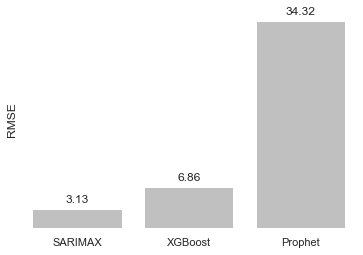

In [154]:
#Plotting the results of the different models. Note we inserted the values manually, just to not have to re run the elevaluations.
graph=sns.barplot(y=[3.13,6.86,34.32], x=[0,1,2], palette=["silver", "silver", "silver"])
plt.xticks(ticks=[0,1,2],labels=["SARIMAX", "XGBoost", "Prophet"])
plt.ylabel("RMSE")
plt.box(False)
plt.yticks([])

#Making the values visible on top of the bars
for p in graph.patches:
    graph.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0.2, 9.3), 
                   textcoords = 'offset points')

plt.show()

# Forecast for total

As mentioned on the report, and as we achieved the best scores with the SARIMAX, to be more consistent, we will only predict to the total using SARIMAX models. In this regard, we will attempt to repeat the full process (with KShape clustering) or just to sum the results achieved per store.

### SARIMAX

In [88]:
#Importing the data at a week level
data_forecast = pd.read_csv("data_forecast.csv")
data_forecast["Date"]=data_forecast["Date"].astype("datetime64")

In [89]:
#We group by Name and Date, to get the total quantities
data_forecast = data_forecast.groupby(["Name", "Date"])["Quantity"].sum().reset_index()

In [90]:
#Spliting between train and test sets
data_forecast_train=data_forecast[data_forecast["Date"]<np.datetime64("2019-09-23")]
data_forecast_test=data_forecast[data_forecast["Date"]>=np.datetime64("2019-09-23")]

#Re-arranging the data and filling the NaN values
data_forecast_train = pd.pivot_table(data=data_forecast_train, index=["Name"], columns="Date", values="Quantity", aggfunc="sum")
data_forecast_train = data_forecast_train.fillna(0)

In [8]:
#Once more, we recurr to the inertia plot to see the optimal number of clusters
inertias=[]
for nr_clusters in range(1,10):
    model= KShape(n_clusters=nr_clusters, max_iter=10, random_state=22)
    labels= model.fit_predict(data_forecast_train)
    inertias.append(model.inertia_)
    
plt.plot(pd.Series(inertias, index=np.arange(1,10)))
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.show()

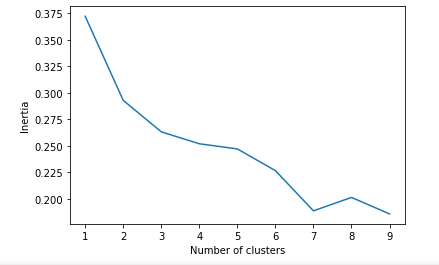

In [91]:
#From the plot, once more, we were divided between 2 or 3 clusters, but, again, we decided to go with 3, in order to offer more diversity.
model= KShape(n_clusters=3, max_iter=10, random_state=22)
data_forecast_train["labels"]= model.fit_predict(data_forecast_train)

Now, we will do everything as before, with the only change being that now we don't have combinations of Store and Name, but have instead only the Name. Therefore, we will not comment the code as much as before.

In [92]:
#Finding the Names per cluster
data_forecast_train = data_forecast_train.reset_index()
clusters = ["cluster0", "cluster1", "cluster2"]

for i in range(3):
    data_cluster = data_forecast_train[data_forecast_train["labels"]==i]
    locals()[clusters[i]] =data_cluster[[ "Name"]].values.tolist()

In [93]:
#Getting the centroids
centroid0 = [item for sublist in model.cluster_centers_[0] for item in sublist]
centroid1 = [item for sublist in model.cluster_centers_[1] for item in sublist]
centroid2 = [item for sublist in model.cluster_centers_[2] for item in sublist]

<AxesSubplot:>

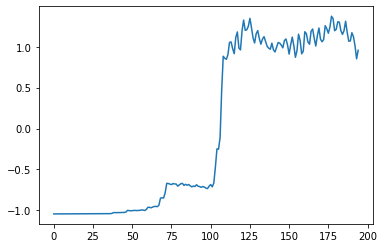

In [13]:
#Plot centroid 0
pd.Series(centroid0).plot()

In [14]:
#Using auto_arima
centroid0 = pd.DataFrame(list(zip(data_forecast_train.columns.values[2:-1], centroid0 ))).set_index(0)
centroidt = auto_arima(centroid0)
centroidt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(5, 1, 4)   Log Likelihood                 290.863
Date:                Fri, 28 May 2021   AIC                           -559.726
Time:                        14:14:07   BIC                           -523.780
Sample:                             0   HQIC                          -545.170
                                - 195                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0159      0.019      0.836      0.403      -0.021       0.053
ar.L1         -0.4243      0.252     -1.681      0.093      -0.919       0.070
ar.L2         -0.4020      0.110     -3.670      0.000      -0.617      -0.187
ar.L3         -0.3374      0.094     -3.580      0.000      -0.522      -0.153
ar.L4          0.2763      0.105      2.636      0.008       0.071       0.482
ar.L5          0.3517      0.211      1.663      0.096      -0.063       0.766
ma.L1          0.9397      0.244      3.853      0.000       0.462       1.418
ma.L2          0.5927      0.157      3.777      0.000       0.285       0.900
ma.L3          0.5181      0.102      5.098      0.000       0.319       0.717
ma.L4          0.4680      0.108      4.338      0.000       0.257       0.679
sigma2         0.0029      0.000     15.988      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              1562.56
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):              77.17   Skew:                             1.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

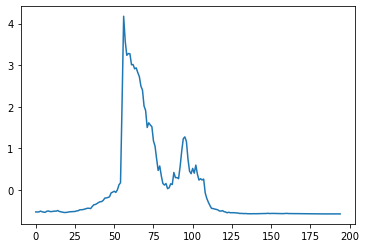

In [15]:
#Plot centroid 1
pd.Series(centroid1).plot()

In [16]:
#Using auto_arima
centroid1 = pd.DataFrame(list(zip(data_forecast_train.columns.values[2:-1], centroid1 ))).set_index(0)
centroid1 = auto_arima(centroid1)
centroid1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  27.551
Date:                Fri, 28 May 2021   AIC                            -51.103
Time:                        14:14:08   BIC                            -44.567
Sample:                             0   HQIC                           -48.456
                                - 195                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4879      0.020     24.097      0.000       0.448       0.528
sigma2         0.0440      0.001     45.334      0.000       0.042       0.046
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             15588.88
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             3.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

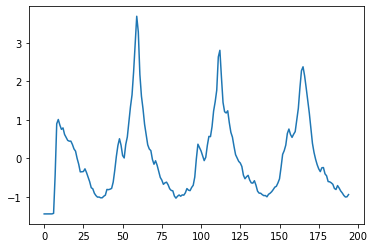

In [17]:
#Plot centroid 2
pd.Series(centroid2).plot()

In [18]:
#Applying the auto_arima
centroid2 = pd.DataFrame(list(zip(data_forecast_train.columns.values[2:-1], centroid2 ))).set_index(0)
centroid2 = auto_arima(centroid2)
centroid2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(2, 0, 3)   Log Likelihood                  66.419
Date:                Fri, 28 May 2021   AIC                           -120.839
Time:                        14:14:17   BIC                           -101.201
Sample:                             0   HQIC                          -112.888
                                - 195                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9146      0.021     93.224      0.000       1.874       1.955
ar.L2         -0.9298      0.020    -46.220      0.000      -0.969      -0.890
ma.L1         -0.0520      0.057     -0.911      0.363      -0.164       0.060
ma.L2         -0.6415      0.048    -13.384      0.000      -0.735      -0.548
ma.L3         -0.2619      0.067     -3.932      0.000      -0.392      -0.131
sigma2         0.0288      0.002     18.241      0.000       0.026       0.032
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               298.77
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
#Re-arranging the dataset
data_forecast_train = data_forecast_train.melt(value_vars=data_forecast_train.columns[1:-1], id_vars=[ "Name", "labels"])

In [95]:
#Diving the dataset per cluster
cluster_0 = data_forecast_train[data_forecast_train["labels"]==0]
cluster_1 = data_forecast_train[data_forecast_train["labels"]==1]
cluster_2 = data_forecast_train[data_forecast_train["labels"]==2]

In [96]:
#We will now follow the same approach as before, with the due changes, and thus the code is not commented.

def find_series_sarima_cluster0 (store):
     """This function receives a Store ID and returns a list of dataframes.
    Each dataframe has as columns 'Date', 'value', 'Name', 'Store', and although the Store ID is always the same as the one 
    passed to the function, the Name will change according to the combinations found in train set.
    This function is specific for the cluster 0, meaning it will get all combinations of products bought by 
    the store in question found in the cluster_0 dataframe."""
        
    sliced=cluster_0[cluster_0.Store==store]
    prods=list(sliced.Name.unique())
    prods.sort()
    series=[]
    for prod in prods:
        serie=pd.DataFrame()
        serie["Date"]=sliced[sliced.Name==prod].Date
        serie["value"]=sliced[sliced.Name==prod].value
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        serie=serie.set_index("Date")
        series.append(serie)
    return series

def find_series_sarima_cluster1 (store):
     """This function receives a Store ID and returns a list of dataframes.
    Each dataframe has as columns 'Date', 'value', 'Name', 'Store', and although the Store ID is always the same as the one 
    passed to the function, the Name will change according to the combinations found in train set.
    This function is specific for the cluster 1, meaning it will get all combinations of products bought by 
    the store in question found in the cluster_1 dataframe."""
    
    sliced=cluster_1[cluster_1.Store==store]
    prods=list(sliced.Name.unique())
    prods.sort()
    series=[]
    for prod in prods:
        serie=pd.DataFrame()
        serie["Date"]=sliced[sliced.Name==prod].Date
        serie["value"]=sliced[sliced.Name==prod].value
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        serie=serie.set_index("Date")
        series.append(serie)
    return series

def find_series_sarima_cluster2 (store):
     """This function receives a Store ID and returns a list of dataframes.
    Each dataframe has as columns 'Date', 'value', 'Name', 'Store', and although the Store ID is always the same as the one 
    passed to the function, the Name will change according to the combinations found in train set.
    This function is specific for the cluster 2, meaning it will get all combinations of products bought by 
    the store in question found in the cluster_2 dataframe."""
    
    sliced=cluster_2[cluster_2.Store==store]
    prods=list(sliced.Name.unique())
    prods.sort()
    series=[]
    for prod in prods:
        serie=pd.DataFrame()
        serie["Date"]=sliced[sliced.Name==prod].Date
        serie["value"]=sliced[sliced.Name==prod].value
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        serie=serie.set_index("Date")
        series.append(serie)
    return series


def run_sarima_cluster0(timeserie_complete):
    """This function receives a time series in the format of a dataframe, with columns 'Date', 'value', 'Name' and 'Store'.
    Applying a SARIMAX model with the parameters appropriate to the cluster 0, the function returns a dataframe with
    the predictions for the period of test, with columns 'Name', 'Store', 'Date' and 'predicted_mean'. """
    
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    #####################################################
    model = sm.tsa.statespace.SARIMAX(timeserie, trend="c", order=(5,1,4), initialization='approximate_diffuse').fit()
    pred = model.predict(np.datetime64("2019-09-23"),np.datetime64("2019-10-28"))
    pred=pd.DataFrame(pred)
    pred["Name"]=[name for i in range(len(pred))]
    pred["Store"]=[POS for i in range(len(pred))]
    pred["Date"]=[np.datetime64("2019-09-23"), np.datetime64("2019-09-30"), np.datetime64("2019-10-07"), np.datetime64("2019-10-14"), np.datetime64("2019-10-21"), np.datetime64("2019-10-28")]
    return pred

def run_sarima_cluster1(timeserie_complete):
    """This function receives a time series in the format of a dataframe, with columns 'Date', 'value', 'Name' and 'Store'.
    Applying a SARIMAX model with the parameters appropriate to the cluster 1, the function returns a dataframe with
    the predictions for the period of test, with columns 'Name', 'Store', 'Date' and 'predicted_mean'. """
    
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    #####################################################
    model = sm.tsa.statespace.SARIMAX(timeserie, order=(0,1,1), initialization='approximate_diffuse').fit()
    pred = model.predict(np.datetime64("2019-09-23"),np.datetime64("2019-10-28"))
    pred=pd.DataFrame(pred)
    pred["Name"]=[name for i in range(len(pred))]
    pred["Store"]=[POS for i in range(len(pred))]
    pred["Date"]=[np.datetime64("2019-09-23"), np.datetime64("2019-09-30"), np.datetime64("2019-10-07"), np.datetime64("2019-10-14"), np.datetime64("2019-10-21"), np.datetime64("2019-10-28")]
    return pred

def run_sarima_cluster2(timeserie_complete):
    """This function receives a time series in the format of a dataframe, with columns 'Date', 'value', 'Name' and 'Store'.
    Applying a SARIMAX model with the parameters appropriate to the cluster 2, the function returns a dataframe with
    the predictions for the period of test, with columns 'Name', 'Store', 'Date' and 'predicted_mean'. """
    
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    #####################################################
  
    model = sm.tsa.statespace.SARIMAX(timeserie , order=(2,0,3), initialization='approximate_diffuse').fit()
    pred = model.predict(np.datetime64("2019-09-23"),np.datetime64("2019-10-28"))
    pred=pd.DataFrame(pred)
    pred["Name"]=[name for i in range(len(pred))]
    pred["Store"]=[POS for i in range(len(pred))]
    pred["Date"]=[np.datetime64("2019-09-23"), np.datetime64("2019-09-30"), np.datetime64("2019-10-07"), np.datetime64("2019-10-14"), np.datetime64("2019-10-21"), np.datetime64("2019-10-28")]
    return pred

         


In [98]:
#Remaning each Store ID as "Total"
cluster_0["Store"] = "Total"
cluster_1["Store"] = "Total"
cluster_2["Store"] = "Total"

In [99]:
#Repeating the same process as previously, we will apply the respective functions to each cluster and store the results in the correspondent list.

#For cluster 0
predictions_0=[]

for store in cluster_0.Store.unique():
    p = mp.Pool(cpu_count())
    series_to_run=find_series_sarima_cluster0(store)
    predictions_0.append(list(p.imap(run_sarima_cluster0, series_to_run )))
    p.close()
    p.join()
    
preds_cluster_0=pd.DataFrame(columns=["predicted_mean", "Name", "Store", "Date"])
for df in predictions_0:
    preds_cluster_0=preds_cluster_0.append(df)
    
preds_cluster_0.reset_index(drop=True, inplace=True)
preds_cluster_0.to_csv("train_total_00_sarima.csv")



#For cluster 1
predictions_1=[]

for store in cluster_1.Store.unique():
    p = mp.Pool(cpu_count())
    series_to_run=find_series_sarima_cluster1(store)
    predictions_1.append(list(p.imap(run_sarima_cluster1, series_to_run )))
    p.close()
    p.join()
    
preds_cluster_1=pd.DataFrame(columns=["predicted_mean", "Name", "Store", "Date"])
for df in predictions_1:
    preds_cluster_1=preds_cluster_1.append(df)
    
preds_cluster_1.reset_index(drop=True, inplace=True)
preds_cluster_1.to_csv("train_total_11_sarima.csv")


#For cluster 2
predictions_2=[]

for store in cluster_2.Store.unique():
    p = mp.Pool(cpu_count())
    series_to_run=find_series_sarima_cluster2(store)
    predictions_2.append(list(p.imap(run_sarima_cluster2, series_to_run )))
    p.close()
    p.join()
    
preds_cluster_2=pd.DataFrame(columns=["predicted_mean", "Name", "Store", "Date"])
for df in predictions_2:
    preds_cluster_2=preds_cluster_2.append(df)
    
preds_cluster_2.reset_index(drop=True, inplace=True)
preds_cluster_2.to_csv("train_total_22_sarima.csv")

In [100]:
#Importing the datasets we just now created
zero = pd.read_csv("train_total_00_sarima.csv").drop("Unnamed: 0", axis=1)
one= pd.read_csv("train_total_11_sarima.csv").drop("Unnamed: 0", axis=1)
two= pd.read_csv("train_total_22_sarima.csv").drop("Unnamed: 0", axis=1)

In [101]:
#doing the usual changes to the dataset, in order to have the actual quantities and to compare results.
predict = zero.append(one, ignore_index= True).append(two, ignore_index= True)
predict["predicted_mean"] = predict["predicted_mean"].apply(lambda x: 0 if x<0 else x).round()
predict["Date"] = predict["Date"].astype("Datetime64")
forecast_comparation = predict.merge(data_forecast_test, how = "left", left_on =["Name", "Date"], right_on =["Name", "Date"])
forecast_comparation["Quantity"] = forecast_comparation["Quantity"].fillna(0)

In [102]:
#Checking our RMSE
mean_squared_error(forecast_comparation["Quantity"], forecast_comparation["predicted_mean"], squared=False)

475.45311122526346

In [103]:
#Seeing, on average, by how many units our predictions failed. We can see that usually the actual quantity is higher than the one we predict
(forecast_comparation["predicted_mean"]-forecast_comparation["Quantity"]).sum()/(len(forecast_comparation["Quantity"]))

-0.8743071161048689

## Simple Sum

We will now predict for all the products but summing the results found in 

In [141]:
#Importing the data at a week level
data_forecast = pd.read_csv("data_forecast.csv")
data_forecast["Date"]=data_forecast["Date"].astype("datetime64")
#We group by Name and Date, to get the total quantities
data_forecast = data_forecast.groupby(["Name", "Date"])["Quantity"].sum().reset_index()

data_forecast_train=data_forecast[data_forecast["Date"]<np.datetime64("2019-09-23")]
data_forecast_test=data_forecast[data_forecast["Date"]>=np.datetime64("2019-09-23")]
data_forecast_train = pd.pivot_table(data=data_forecast_train, index=["Name"], columns="Date", values="Quantity", aggfunc="sum")
data_forecast_train = data_forecast_train.fillna(0)

In [144]:
#Importing the predictions from each cluster
zero = pd.read_csv("train_00_sarima.csv").drop("Unnamed: 0", axis=1)
one= pd.read_csv("train_11_sarima.csv").drop("Unnamed: 0", axis=1)
two= pd.read_csv("train_22_sarima.csv").drop("Unnamed: 0", axis=1)

#Joining all predictions into one dataframe
predict = zero.append(one, ignore_index= True).append(two, ignore_index= True)

#Making sure that the negative values are considered as zeros and that we only have integer values
predict["predicted_mean"] = predict["predicted_mean"].apply(lambda x: 0 if x<0 else x).round()

#Setting the Date as satetime
predict["Date"] = predict["Date"].astype("Datetime64")

#Summing all products per store, in order for each to only have total quantity
predict = predict.groupby(["Name", "Date"])["predicted_mean"].sum().reset_index()

In [149]:
#getting the real quantities, in order to find how good was our model
forecast_comparation = predict.merge(data_forecast_test, how = "left", left_on =["Name", "Date"], right_on =["Name", "Date"])
forecast_comparation["Quantity"] = forecast_comparation["Quantity"].fillna(0)

In [151]:
#Computing the RMSE error
mean_squared_error(forecast_comparation["Quantity"], forecast_comparation["predicted_mean"], squared=False)

512.7506272719618

### Comparing Results

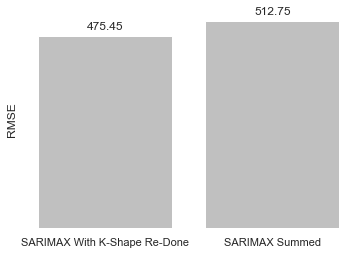

In [157]:
#Plotting the results of the different models. Note we inserted the values manually, just to not have to re run the elevaluations.
graph=sns.barplot(y=[475.45, 512.75], x=[0,1], palette=["silver", "silver"])
plt.xticks(ticks=[0,1],labels=["SARIMAX With K-Shape Re-Done", "SARIMAX Summed"])
plt.ylabel("RMSE")
plt.box(False)
plt.yticks([])

#Making the values visible on top of the bars
for p in graph.patches:
    graph.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0.2, 9.3), 
                   textcoords = 'offset points')

plt.show()

# FINAL MODEL: Per Store Per Product

As the SARIMAX was the model which had the best results, following the same approach as before, we will use it to predict for the 6 weeks which follow the ones present in the dataset provided, for each store, for each product.

In [2]:
#Importing the dataset with weekly data
data_forecast = pd.read_csv("data_forecast.csv")
data_forecast["Date"]=data_forecast["Date"].astype("datetime64")

In [3]:
#Getting the total quantities
data_forecast = data_forecast.groupby(["Name","Store", "Date"])["Quantity"].sum().reset_index()

In [4]:
#Re-arranging the data
data_forecast= pd.pivot_table(data=data_forecast, index=["Store", "Name"], columns="Date", values="Quantity", aggfunc="sum")
data_forecast_train = data_forecast.fillna(0)

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [6]:
#Plotting the inertia plot, in order to find the optimal number of clusters
inertias=[]
for nr_clusters in range(1,14):
    model= KShape(n_clusters=nr_clusters, max_iter=10, random_state=22)
    labels= model.fit_predict(data_forecast_train)
    inertias.append(model.inertia_)
    
plt.plot(pd.Series(inertias, index=np.arange(1,14)))
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.show()

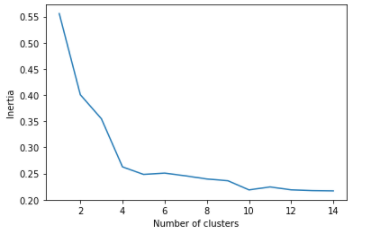

In [5]:
#Here, accoridng to the plot, we found 4 to be the right amount of clusters
model= KShape(n_clusters=4, max_iter=10, random_state=22)
data_forecast_train["labels"]= model.fit_predict(data_forecast_train)

In [7]:
#Turning the dataset into the right format
data_forecast_train = data_forecast_train.reset_index()

In [8]:
#Once more, getting the Store and Name combinations per cluster

clusters = ["cluster0", "cluster1", "cluster2", "cluster3"]

for i in range(4):
    data_cluster = data_forecast_train[data_forecast_train["labels"]==i]
    locals()[clusters[i]] =data_cluster[["Store", "Name"]].values.tolist()

In [9]:
#Stroing the centroids for each cluster
centroid0 = [item for sublist in model.cluster_centers_[0] for item in sublist]
centroid1 = [item for sublist in model.cluster_centers_[1] for item in sublist]
centroid2 = [item for sublist in model.cluster_centers_[2] for item in sublist]
centroid3 = [item for sublist in model.cluster_centers_[3] for item in sublist]

<AxesSubplot:>

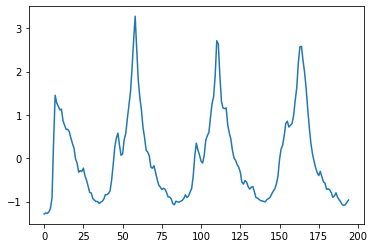

In [151]:
#Centroid 0 plot
pd.Series(centroid0).plot()

In [152]:
#Finding the best SARIMAX model for cluster 0
centroid0 = pd.DataFrame(list(zip(data_forecast_train.columns.values[2:-1], centroid0 ))).set_index(0)
centroidt = auto_arima(centroid0)
centroidt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(1, 0, 2)   Log Likelihood                  49.616
Date:                Tue, 25 May 2021   AIC                            -91.231
Time:                        16:17:03   BIC                            -78.139
Sample:                             0   HQIC                           -85.931
                                - 195                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9186      0.020     45.744      0.000       0.879       0.958
ma.L1          0.8785      0.059     14.913      0.000       0.763       0.994
ma.L2          0.3384      0.055      6.181      0.000       0.231       0.446
sigma2         0.0345      0.002     19.434      0.000       0.031       0.038
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               580.60
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

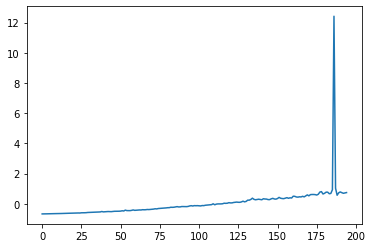

In [153]:
#Centroid 1 plot
pd.Series(centroid1).plot()

In [154]:
#finding best model for cluster 1
centroid1 = pd.DataFrame(list(zip(data_forecast_train.columns.values[2:-1], centroid1 ))).set_index(0)

centroid1 = auto_arima(centroid1)
centroid1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -244.036
Date:                Tue, 25 May 2021   AIC                            494.072
Time:                        16:17:04   BIC                            503.876
Sample:                             0   HQIC                           498.042
                                - 195                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0100      0.029      0.350      0.727      -0.046       0.066
ma.L1         -0.9687      0.106     -9.145      0.000      -1.176      -0.761
sigma2         0.7144      0.117      6.106      0.000       0.485       0.944
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):            283168.53
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):             246.34   Skew:                            13.61
Prob(H) (two-sided):                  0.00   Kurtosis:                       188.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

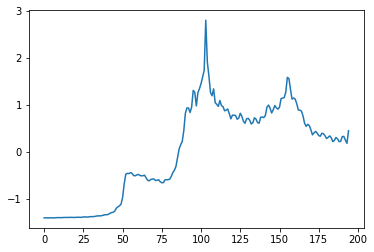

In [155]:
#Plot centroid cluster 2
pd.Series(centroid2).plot()

In [156]:
#fiding best model for cluster 2
centroid2 = pd.DataFrame(list(zip(data_forecast_train.columns.values[2:-1], centroid2 ))).set_index(0)
centroid2 = auto_arima(centroid2)
centroid2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 121.594
Date:                Tue, 25 May 2021   AIC                           -231.188
Time:                        16:17:07   BIC                           -211.581
Sample:                             0   HQIC                          -223.248
                                - 195                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0161      0.019      0.857      0.392      -0.021       0.053
ar.L1          0.2545      0.039      6.451      0.000       0.177       0.332
ar.L2         -0.9880      0.032    -30.662      0.000      -1.051      -0.925
ma.L1         -0.2576      0.056     -4.634      0.000      -0.367      -0.149
ma.L2          0.9383      0.051     18.263      0.000       0.838       1.039
sigma2         0.0162      0.001     26.332      0.000       0.015       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7116.64
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

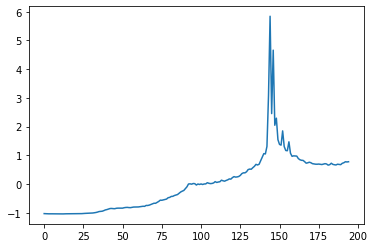

In [157]:
#Plot centroid of cluster 3
pd.Series(centroid3).plot()

In [158]:
#Find best model for cluster 3
centroid3 = pd.DataFrame(list(zip(data_forecast_train.columns.values[2:-1], centroid3))).set_index(0)
centroid3 = auto_arima(centroid3)
centroid3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 -81.036
Date:                Tue, 25 May 2021   AIC                            168.072
Time:                        16:17:09   BIC                            177.876
Sample:                             0   HQIC                           172.042
                                - 195                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4546      0.015    -31.274      0.000      -0.483      -0.426
ar.L2          0.1021      0.021      4.974      0.000       0.062       0.142
sigma2         0.1348      0.003     49.158      0.000       0.129       0.140
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             24277.51
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):            3522.92   Skew:                             3.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
#Re-arranging the dataset
data_forecast_train = data_forecast_train.melt(value_vars=data_forecast_train.columns[2:-1], id_vars=["Store", "Name", "labels"])

In [11]:
#Diving the dataset per cluster
cluster_0 = data_forecast_train[data_forecast_train["labels"]==0]
cluster_1 = data_forecast_train[data_forecast_train["labels"]==1]
cluster_2 = data_forecast_train[data_forecast_train["labels"]==2]
cluster_3 =  data_forecast_train[data_forecast_train["labels"]==3]

In [13]:
#Once more, the process is the same, is only adapted to the situation (change in dates), and thus we will not comment it.

def find_series_sarima_cluster0 (store):
    
     """This function receives a Store ID (integer) and returns a list of dataframes.
    Each dataframe has as columns 'Date', 'value', 'Name', 'Store', and although the Store ID is always the same as the one 
    passed to the function, the Name will change according to the combinations found in train set.
    This function is specific for the cluster 0, meaning it will get all combinations of products bought by 
    the store in question found in the cluster_0 dataframe."""
    
    sliced=cluster_0[cluster_0.Store==store]
    prods=list(sliced.Name.unique())
    prods.sort()
    series=[]
    for prod in prods:
        serie=pd.DataFrame()
        serie["Date"]=sliced[sliced.Name==prod].Date
        serie["value"]=sliced[sliced.Name==prod].value
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        serie=serie.set_index("Date")
        series.append(serie)
    return series

def find_series_sarima_cluster1 (store):
       """This function receives a Store ID (integer) and returns a list of dataframes.
    Each dataframe has as columns 'Date', 'value', 'Name', 'Store', and although the Store ID is always the same as the one 
    passed to the function, the Name will change according to the combinations found in train set.
    This function is specific for the cluster 1, meaning it will get all combinations of products bought by 
    the store in question found in the cluster_1 dataframe."""
    
    sliced=cluster_1[cluster_1.Store==store]
    prods=list(sliced.Name.unique())
    prods.sort()
    series=[]
    for prod in prods:
        serie=pd.DataFrame()
        serie["Date"]=sliced[sliced.Name==prod].Date
        serie["value"]=sliced[sliced.Name==prod].value
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        serie=serie.set_index("Date")
        series.append(serie)
    return series

def find_series_sarima_cluster2 (store):
    
       """This function receives a Store ID (integer) and returns a list of dataframes.
    Each dataframe has as columns 'Date', 'value', 'Name', 'Store', and although the Store ID is always the same as the one 
    passed to the function, the Name will change according to the combinations found in train set.
    This function is specific for the cluster 2, meaning it will get all combinations of products bought by 
    the store in question found in the cluster_2 dataframe."""
        
    sliced=cluster_2[cluster_2.Store==store]
    prods=list(sliced.Name.unique())
    prods.sort()
    series=[]
    for prod in prods:
        serie=pd.DataFrame()
        serie["Date"]=sliced[sliced.Name==prod].Date
        serie["value"]=sliced[sliced.Name==prod].value
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        serie=serie.set_index("Date")
        series.append(serie)
    return series

def find_series_sarima_cluster3 (store):
       """This function receives a Store ID (integer) and returns a list of dataframes.
    Each dataframe has as columns 'Date', 'value', 'Name', 'Store', and although the Store ID is always the same as the one 
    passed to the function, the Name will change according to the combinations found in train set.
    This function is specific for the cluster 3, meaning it will get all combinations of products bought by 
    the store in question found in the cluster_3 dataframe."""
    
    sliced=cluster_3[cluster_3.Store==store]
    prods=list(sliced.Name.unique())
    prods.sort()
    series=[]
    for prod in prods:
        serie=pd.DataFrame()
        serie["Date"]=sliced[sliced.Name==prod].Date
        serie["value"]=sliced[sliced.Name==prod].value
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        serie=serie.set_index("Date")
        series.append(serie)
    return series

def run_sarima_cluster0(timeserie_complete):
    """This function receives a time series in the format of a dataframe, with columns 'Date', 'value', 'Name' and 'Store'.
    Applying a SARIMAX model with the parameters appropriate to the cluster 0, the function returns a dataframe with
    the predictions for the period of test, with columns 'Name', 'Store', 'Date' and 'predicted_mean'. """
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    #####################################################
    model = sm.tsa.statespace.SARIMAX(timeserie, trend=None, order=(1,0,2), initialization='approximate_diffuse').fit()
    pred = model.predict(np.datetime64("2019-11-04"),np.datetime64("2019-12-09"))
    pred=pd.DataFrame(pred)
    pred["Name"]=[name for i in range(len(pred))]
    pred["Store"]=[POS for i in range(len(pred))]
    pred["Date"]=[np.datetime64("2019-11-04"), np.datetime64("2019-11-11"), np.datetime64("2019-11-18"), np.datetime64("2019-11-25"), np.datetime64("2019-12-02"), np.datetime64("2019-12-09")]
    return pred

def run_sarima_cluster1(timeserie_complete):
    """This function receives a time series in the format of a dataframe, with columns 'Date', 'value', 'Name' and 'Store'.
    Applying a SARIMAX model with the parameters appropriate to the cluster 1, the function returns a dataframe with
    the predictions for the period of test, with columns 'Name', 'Store', 'Date' and 'predicted_mean'. """
    
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    #####################################################
    model = sm.tsa.statespace.SARIMAX(timeserie, trend="c", order=(0,1,1), initialization='approximate_diffuse').fit()
    pred = model.predict(np.datetime64("2019-11-04"),np.datetime64("2019-12-09"))
    pred=pd.DataFrame(pred)
    pred["Name"]=[name for i in range(len(pred))]
    pred["Store"]=[POS for i in range(len(pred))]
    pred["Date"]=[np.datetime64("2019-11-04"), np.datetime64("2019-11-11"), np.datetime64("2019-11-18"), np.datetime64("2019-11-25"), np.datetime64("2019-12-02"), np.datetime64("2019-12-09")]
    return pred

def run_sarima_cluster2(timeserie_complete):
    """This function receives a time series in the format of a dataframe, with columns 'Date', 'value', 'Name' and 'Store'.
    Applying a SARIMAX model with the parameters appropriate to the cluster 2, the function returns a dataframe with
    the predictions for the period of test, with columns 'Name', 'Store', 'Date' and 'predicted_mean'. """
    
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    #####################################################
    model = sm.tsa.statespace.SARIMAX(timeserie, trend="c", order=(2,1,2), initialization='approximate_diffuse').fit()
    pred = model.predict(np.datetime64("2019-11-04"),np.datetime64("2019-12-09"))
    pred=pd.DataFrame(pred)
    pred["Name"]=[name for i in range(len(pred))]
    pred["Store"]=[POS for i in range(len(pred))]
    pred["Date"]=[np.datetime64("2019-11-04"), np.datetime64("2019-11-11"), np.datetime64("2019-11-18"), np.datetime64("2019-11-25"), np.datetime64("2019-12-02"), np.datetime64("2019-12-09")]
    return pred

def run_sarima_cluster3(timeserie_complete):
    """This function receives a time series in the format of a dataframe, with columns 'Date', 'value', 'Name' and 'Store'.
    Applying a SARIMAX model with the parameters appropriate to the cluster 3, the function returns a dataframe with
    the predictions for the period of test, with columns 'Name', 'Store', 'Date' and 'predicted_mean'. """
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    #####################################################
    model = sm.tsa.statespace.SARIMAX(timeserie, trend=None, order=(2,1,0), initialization='approximate_diffuse').fit()
    pred = model.predict(np.datetime64("2019-11-04"),np.datetime64("2019-12-09"))
    pred=pd.DataFrame(pred)
    pred["Name"]=[name for i in range(len(pred))]
    pred["Store"]=[POS for i in range(len(pred))]
    pred["Date"]=[np.datetime64("2019-11-04"), np.datetime64("2019-11-11"), np.datetime64("2019-11-18"), np.datetime64("2019-11-25"), np.datetime64("2019-12-02"), np.datetime64("2019-12-09")]
    return pred

In [14]:
#Getting the predictions for each cluster, recurring to the previous functions, as before.

#For cluster 0
predictions_0=[]

for store in cluster_0.Store.unique():
    p = mp.Pool(cpu_count())
    series_to_run=find_series_sarima_cluster0(store)
    predictions_0.append(list(p.imap(run_sarima_cluster0, series_to_run )))
    p.close()
    p.join()
    
preds_cluster_0=pd.DataFrame(columns=["predicted_mean", "Name", "Store", "Date"])
for df in predictions_0:
    preds_cluster_0=preds_cluster_0.append(df)
    
preds_cluster_0.reset_index(drop=True, inplace=True)
preds_cluster_0.to_csv("final_cluster0_sarima.csv")



#For cluster 1
predictions_1=[]

for store in cluster_1.Store.unique():
    p = mp.Pool(cpu_count())
    series_to_run=find_series_sarima_cluster1(store)
    predictions_1.append(list(p.imap(run_sarima_cluster1, series_to_run )))
    p.close()
    p.join()
    
preds_cluster_1=pd.DataFrame(columns=["predicted_mean", "Name", "Store", "Date"])
for df in predictions_1:
    preds_cluster_1=preds_cluster_1.append(df)
    
preds_cluster_1.reset_index(drop=True, inplace=True)
preds_cluster_1.to_csv("final_cluster1_sarima.csv")



#For cluster 2
predictions_2=[]

for store in cluster_2.Store.unique():
    p = mp.Pool(cpu_count())
    series_to_run=find_series_sarima_cluster2(store)
    predictions_2.append(list(p.imap(run_sarima_cluster2, series_to_run )))
    p.close()
    p.join()
    
preds_cluster_2=pd.DataFrame(columns=["predicted_mean", "Name", "Store", "Date"])
for df in predictions_2:
    preds_cluster_2=preds_cluster_2.append(df)
    
preds_cluster_2.reset_index(drop=True, inplace=True)
preds_cluster_2.to_csv("final_cluster2_sarima.csv")



#For cluster 3
predictions_3=[]

for store in cluster_3.Store.unique():
    p = mp.Pool(cpu_count())
    series_to_run=find_series_sarima_cluster3(store)
    predictions_3.append(list(p.imap(run_sarima_cluster3, series_to_run )))
    p.close()
    p.join()
    
preds_cluster_3=pd.DataFrame(columns=["predicted_mean", "Name", "Store", "Date"])
for df in predictions_3:
    preds_cluster_3=preds_cluster_3.append(df)
    
preds_cluster_3.reset_index(drop=True, inplace=True)
preds_cluster_3.to_csv("final_cluster3_sarima.csv")

In [15]:
#Importing all the datasets
zero = pd.read_csv("final_cluster0_sarima.csv").drop("Unnamed: 0", axis=1)
one= pd.read_csv("final_cluster1_sarima.csv").drop("Unnamed: 0", axis=1)
two= pd.read_csv("final_cluster2_sarima.csv").drop("Unnamed: 0", axis=1)
three=pd.read_csv("final_cluster3_sarima.csv").drop("Unnamed: 0", axis=1)

In [16]:
#Joining all datasets into one, making the necessary changes
predict = zero.append(one, ignore_index= True).append(two, ignore_index= True).append(three, ignore_index= True)
predict["predicted_mean"] = predict["predicted_mean"].apply(lambda x: 0 if x<0 else x).round()
predict["Date"] = predict["Date"].astype("Datetime64")

In [31]:
#checking our final predictions and saving them
predict.to_csv("Per_Store_Predict.csv")
predict

predicted_mean  Name  Store       Date
0                  18.0    55      1 2019-11-04
1                  17.0    55      1 2019-11-11
2                  17.0    55      1 2019-11-18
3                  17.0    55      1 2019-11-25
4                  17.0    55      1 2019-12-02
...                 ...   ...    ...        ...
2819491            26.0  2847    410 2019-11-11
2819492            17.0  2847    410 2019-11-18
2819493            20.0  2847    410 2019-11-25
2819494            22.0  2847    410 2019-12-02
2819495            20.0  2847    410 2019-12-09

[2819496 rows x 4 columns]

# FINAL MODEL: Total

In [53]:
#Importing the dataset with data at a weekly level
data_forecast = pd.read_csv("data_forecast.csv")
data_forecast["Date"]=data_forecast["Date"].astype("datetime64")

In [54]:
#Grouping the data by Name and Date to get the total quantities sold
data_forecast = data_forecast.groupby(["Name", "Date"])["Quantity"].sum().reset_index()

In [55]:
#Re-arranging the dataset
data_forecast_train = pd.pivot_table(data=data_forecast, index=["Name"], columns="Date", values="Quantity", aggfunc="sum")
data_forecast_train = data_forecast_train.fillna(0)

In [37]:
#Recurring to a inertia plot to find the optimal number of scores
inertias=[]
for nr_clusters in range(1,10):
    model= KShape(n_clusters=nr_clusters, max_iter=10, random_state=22)
    labels= model.fit_predict(data_forecast_train)
    inertias.append(model.inertia_)
    
plt.plot(pd.Series(inertias, index=np.arange(1,10)))
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.show()

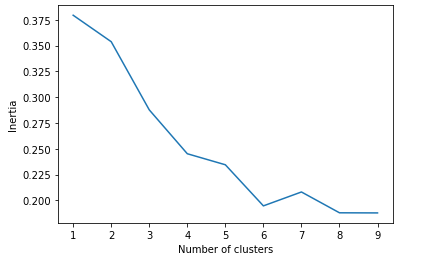

In [56]:
#We decided the best number of clusters was 4
model= KShape(n_clusters=4, max_iter=10, random_state=22)
data_forecast_train["labels"]= model.fit_predict(data_forecast_train)

In [57]:
#Re-arranging the dataset
data_forecast_train = data_forecast_train.reset_index()

In [58]:
#Getting the names present in each cluster

clusters = ["cluster0", "cluster1", "cluster2", "cluster3"]

for i in range(4):
    data_cluster = data_forecast_train[data_forecast_train["labels"]==i]
    locals()[clusters[i]] =data_cluster[["Name"]].values.tolist()

In [59]:
#Finding the centroids
centroid0 = [item for sublist in model.cluster_centers_[0] for item in sublist]
centroid1 = [item for sublist in model.cluster_centers_[1] for item in sublist]
centroid2 = [item for sublist in model.cluster_centers_[2] for item in sublist]
centroid3 = [item for sublist in model.cluster_centers_[3] for item in sublist]

<AxesSubplot:>

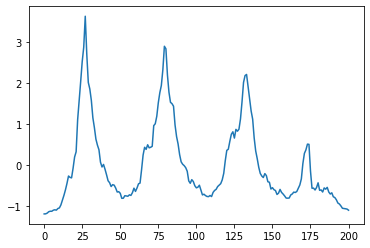

In [60]:
#Plot centoid cluster 0
pd.Series(centroid0).plot()

In [61]:
#Best model for cluster 0
centroid0 = pd.DataFrame(list(zip(data_forecast_train.columns.values[2:-1], centroid0 ))).set_index(0)
centroidt = auto_arima(centroid0)
centroidt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(2, 0, 2)   Log Likelihood                  62.462
Date:                Sat, 29 May 2021   AIC                           -114.924
Time:                        09:15:12   BIC                            -98.432
Sample:                             0   HQIC                          -108.250
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9203      0.052     36.722      0.000       1.818       2.023
ar.L2         -0.9373      0.048    -19.460      0.000      -1.032      -0.843
ma.L1         -0.4701      0.088     -5.318      0.000      -0.643      -0.297
ma.L2         -0.3315      0.087     -3.796      0.000      -0.503      -0.160
sigma2         0.0307      0.002     20.151      0.000       0.028       0.034
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1589.03
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

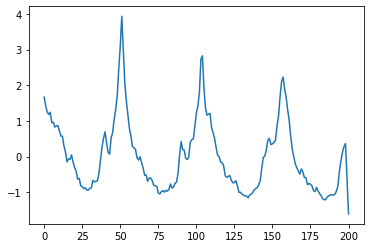

In [62]:
#Plot centroid cluster 1
pd.Series(centroid1).plot()

In [63]:
#Best parameters for model for cluster 1
centroid1 = pd.DataFrame(list(zip(data_forecast_train.columns.values[2:-1], centroid1 ))).set_index(0)

centroid1 = auto_arima(centroid1)
centroid1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  19.952
Date:                Sat, 29 May 2021   AIC                            -33.904
Time:                        09:15:14   BIC                            -24.009
Sample:                             0   HQIC                           -29.900
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5154      0.053     28.578      0.000       1.411       1.619
ar.L2         -0.5654      0.063     -8.939      0.000      -0.689      -0.441
sigma2         0.0471      0.002     19.474      0.000       0.042       0.052
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               592.41
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -1.03
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

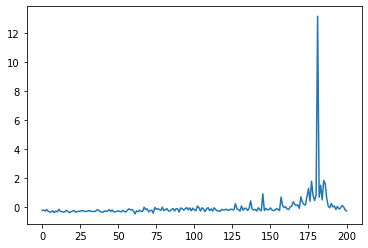

In [64]:
#Plot centroid cluster 2
pd.Series(centroid2).plot()

In [65]:
#Best model for cluster 2
centroid2 = pd.DataFrame(list(zip(data_forecast_train.columns.values[2:-1], centroid2 ))).set_index(0)
centroid2 = auto_arima(centroid2)
centroid2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -274.313
Date:                Sat, 29 May 2021   AIC                            552.627
Time:                        09:15:15   BIC                            559.213
Sample:                             0   HQIC                           555.292
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8619      0.030    -28.745      0.000      -0.921      -0.803
sigma2         0.9159      0.014     64.591      0.000       0.888       0.944
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):            177620.44
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):             666.91   Skew:                            11.17
Prob(H) (two-sided):                  0.00   Kurtosis:                       147.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

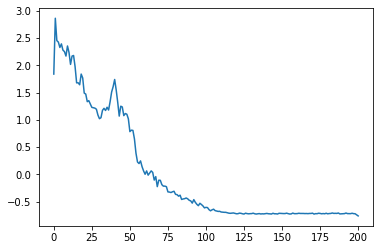

In [66]:
#Plot centroid of cluster 3
pd.Series(centroid3).plot()

In [67]:
#Best model for cluster 3
centroid3 = pd.DataFrame(list(zip(data_forecast_train.columns.values[2:-1], centroid3))).set_index(0)
centroid3 = auto_arima(centroid3)
centroid3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(4, 1, 0)   Log Likelihood                 169.881
Date:                Sat, 29 May 2021   AIC                           -327.763
Time:                        09:15:21   BIC                           -308.003
Sample:                             0   HQIC                          -319.766
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0168      0.011     -1.601      0.109      -0.037       0.004
ar.L1         -0.2291      0.056     -4.062      0.000      -0.340      -0.119
ar.L2         -0.0189      0.044     -0.431      0.667      -0.105       0.067
ar.L3         -0.2099      0.051     -4.135      0.000      -0.309      -0.110
ar.L4          0.2540      0.038      6.627      0.000       0.179       0.329
sigma2         0.0106      0.001     19.944      0.000       0.010       0.012
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):              7334.57
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                             2.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
#Re-arranging the dataset
data_forecast_train = data_forecast_train.melt(value_vars=data_forecast_train.columns[1:-1], id_vars=[ "Name", "labels"])

In [70]:
#Dividing dataset per cluster
cluster_0 = data_forecast_train[data_forecast_train["labels"]==0]
cluster_1 = data_forecast_train[data_forecast_train["labels"]==1]
cluster_2 = data_forecast_train[data_forecast_train["labels"]==2]
cluster_3 =  data_forecast_train[data_forecast_train["labels"]==3]

In [71]:
#Again, the rational is the same as before and thus we will not comment this cell

def find_series_sarima_cluster0 (store):
       """This function receives a Store ID and returns a list of dataframes.
    Each dataframe has as columns 'Date', 'value', 'Name', 'Store', and although the Store ID is always the same as the one 
    passed to the function, the Name will change according to the combinations found in train set.
    This function is specific for the cluster 0, meaning it will get all combinations of products bought by 
    the store in question found in the cluster_0 dataframe."""
    
    sliced=cluster_0[cluster_0.Store==store]
    prods=list(sliced.Name.unique())
    prods.sort()
    series=[]
    for prod in prods:
        serie=pd.DataFrame()
        serie["Date"]=sliced[sliced.Name==prod].Date
        serie["value"]=sliced[sliced.Name==prod].value
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        serie=serie.set_index("Date")
        series.append(serie)
    return series

def find_series_sarima_cluster1 (store):
     """This function receives a Store ID and returns a list of dataframes.
    Each dataframe has as columns 'Date', 'value', 'Name', 'Store', and although the Store ID is always the same as the one 
    passed to the function, the Name will change according to the combinations found in train set.
    This function is specific for the cluster 1, meaning it will get all combinations of products bought by 
    the store in question found in the cluster_1 dataframe."""
    
    sliced=cluster_1[cluster_1.Store==store]
    prods=list(sliced.Name.unique())
    prods.sort()
    series=[]
    for prod in prods:
        serie=pd.DataFrame()
        serie["Date"]=sliced[sliced.Name==prod].Date
        serie["value"]=sliced[sliced.Name==prod].value
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        serie=serie.set_index("Date")
        series.append(serie)
    return series

def find_series_sarima_cluster2 (store):
     """This function receives a Store ID and returns a list of dataframes.
    Each dataframe has as columns 'Date', 'value', 'Name', 'Store', and although the Store ID is always the same as the one 
    passed to the function, the Name will change according to the combinations found in train set.
    This function is specific for the cluster 2, meaning it will get all combinations of products bought by 
    the store in question found in the cluster_2 dataframe."""
        
    sliced=cluster_2[cluster_2.Store==store]
    prods=list(sliced.Name.unique())
    prods.sort()
    series=[]
    for prod in prods:
        serie=pd.DataFrame()
        serie["Date"]=sliced[sliced.Name==prod].Date
        serie["value"]=sliced[sliced.Name==prod].value
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        serie=serie.set_index("Date")
        series.append(serie)
    return series

def find_series_sarima_cluster3 (store):
     """This function receives a Store ID and returns a list of dataframes.
    Each dataframe has as columns 'Date', 'value', 'Name', 'Store', and although the Store ID is always the same as the one 
    passed to the function, the Name will change according to the combinations found in train set.
    This function is specific for the cluster 3, meaning it will get all combinations of products bought by 
    the store in question found in the cluster_3 dataframe."""
    
    sliced=cluster_3[cluster_3.Store==store]
    prods=list(sliced.Name.unique())
    prods.sort()
    series=[]
    for prod in prods:
        serie=pd.DataFrame()
        serie["Date"]=sliced[sliced.Name==prod].Date
        serie["value"]=sliced[sliced.Name==prod].value
        serie["Name"]=[prod for i in range(len(serie))]
        serie["Store"]=[store for i in range(len(serie))]
        serie=serie.set_index("Date")
        series.append(serie)
    return series

def run_sarima_cluster0(timeserie_complete):
    """This function receives a time series in the format of a dataframe, with columns 'Date', 'value', 'Name' and 'Store'.
    Applying a SARIMAX model with the parameters appropriate to the cluster 0, the function returns a dataframe with
    the predictions for the period of test, with columns 'Name', 'Store', 'Date' and 'predicted_mean'. """
    
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    #####################################################
    model = sm.tsa.statespace.SARIMAX(timeserie, order=(2,0,2), initialization='approximate_diffuse').fit()
    pred = model.predict(np.datetime64("2019-11-04"),np.datetime64("2019-12-09"))
    pred=pd.DataFrame(pred)
    pred["Name"]=[name for i in range(len(pred))]
    pred["Store"]=[POS for i in range(len(pred))]
    pred["Date"]=[np.datetime64("2019-11-04"), np.datetime64("2019-11-11"), np.datetime64("2019-11-18"), np.datetime64("2019-11-25"), np.datetime64("2019-12-02"), np.datetime64("2019-12-09")]
    return pred

def run_sarima_cluster1(timeserie_complete):
    """This function receives a time series in the format of a dataframe, with columns 'Date', 'value', 'Name' and 'Store'.
    Applying a SARIMAX model with the parameters appropriate to the cluster 1, the function returns a dataframe with
    the predictions for the period of test, with columns 'Name', 'Store', 'Date' and 'predicted_mean'. """
    
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    #####################################################
    model = sm.tsa.statespace.SARIMAX(timeserie, order=(2,0,0), initialization='approximate_diffuse').fit()
    pred = model.predict(np.datetime64("2019-11-04"),np.datetime64("2019-12-09"))
    pred=pd.DataFrame(pred)
    pred["Name"]=[name for i in range(len(pred))]
    pred["Store"]=[POS for i in range(len(pred))]
    pred["Date"]=[np.datetime64("2019-11-04"), np.datetime64("2019-11-11"), np.datetime64("2019-11-18"), np.datetime64("2019-11-25"), np.datetime64("2019-12-02"), np.datetime64("2019-12-09")]
    return pred

def run_sarima_cluster2(timeserie_complete):
    """This function receives a time series in the format of a dataframe, with columns 'Date', 'value', 'Name' and 'Store'.
    Applying a SARIMAX model with the parameters appropriate to the cluster 2, the function returns a dataframe with
    the predictions for the period of test, with columns 'Name', 'Store', 'Date' and 'predicted_mean'. """
    
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    #####################################################
    model = sm.tsa.statespace.SARIMAX(timeserie, order=(0,1,1), initialization='approximate_diffuse').fit()
    pred = model.predict(np.datetime64("2019-11-04"),np.datetime64("2019-12-09"))
    pred=pd.DataFrame(pred)
    pred["Name"]=[name for i in range(len(pred))]
    pred["Store"]=[POS for i in range(len(pred))]
    pred["Date"]=[np.datetime64("2019-11-04"), np.datetime64("2019-11-11"), np.datetime64("2019-11-18"), np.datetime64("2019-11-25"), np.datetime64("2019-12-02"), np.datetime64("2019-12-09")]
    return pred

def run_sarima_cluster3(timeserie_complete):
    """This function receives a time series in the format of a dataframe, with columns 'Date', 'value', 'Name' and 'Store'.
    Applying a SARIMAX model with the parameters appropriate to the cluster 3, the function returns a dataframe with
    the predictions for the period of test, with columns 'Name', 'Store', 'Date' and 'predicted_mean'. """
    
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    
    timeserie=timeserie_complete.drop(["Name", "Store"], axis=1)
    name=timeserie_complete.Name.values[0]
    POS=timeserie_complete.Store.values[0]
    #####################################################
    model = sm.tsa.statespace.SARIMAX(timeserie, trend="c", order=(4,1,0), initialization='approximate_diffuse').fit()
    pred = model.predict(np.datetime64("2019-11-04"),np.datetime64("2019-12-09"))
    pred=pd.DataFrame(pred)
    pred["Name"]=[name for i in range(len(pred))]
    pred["Store"]=[POS for i in range(len(pred))]
    pred["Date"]=[np.datetime64("2019-11-04"), np.datetime64("2019-11-11"), np.datetime64("2019-11-18"), np.datetime64("2019-11-25"), np.datetime64("2019-12-02"), np.datetime64("2019-12-09")]
    return pred

In [73]:
#Defining the Store as "Total"
cluster_0["Store"] = "Total"
cluster_1["Store"] = "Total"
cluster_2["Store"] = "Total"
cluster_3["Store"] = "Total"

In [74]:
#Once more, repeating the same process, finding the predictions for each cluster

#Cluster 0
predictions_0=[]

for store in cluster_0.Store.unique():
    p = mp.Pool(cpu_count())
    series_to_run=find_series_sarima_cluster0(store)
    predictions_0.append(list(p.imap(run_sarima_cluster0, series_to_run )))
    p.close()
    p.join()
    
preds_cluster_0=pd.DataFrame(columns=["predicted_mean", "Name", "Store", "Date"])
for df in predictions_0:
    preds_cluster_0=preds_cluster_0.append(df)
    
preds_cluster_0.reset_index(drop=True, inplace=True)
preds_cluster_0.to_csv("final_total0_sarima.csv")



#cluster 1
predictions_1=[]

for store in cluster_1.Store.unique():
    p = mp.Pool(cpu_count())
    series_to_run=find_series_sarima_cluster1(store)
    predictions_1.append(list(p.imap(run_sarima_cluster1, series_to_run )))
    p.close()
    p.join()
    
preds_cluster_1=pd.DataFrame(columns=["predicted_mean", "Name", "Store", "Date"])
for df in predictions_1:
    preds_cluster_1=preds_cluster_1.append(df)
    
preds_cluster_1.reset_index(drop=True, inplace=True)
preds_cluster_1.to_csv("final_total1_sarima.csv")


#Cluster 2
predictions_2=[]

for store in cluster_2.Store.unique():
    p = mp.Pool(cpu_count())
    series_to_run=find_series_sarima_cluster2(store)
    predictions_2.append(list(p.imap(run_sarima_cluster2, series_to_run )))
    p.close()
    p.join()
    
preds_cluster_2=pd.DataFrame(columns=["predicted_mean", "Name", "Store", "Date"])
for df in predictions_2:
    preds_cluster_2=preds_cluster_2.append(df)
    
preds_cluster_2.reset_index(drop=True, inplace=True)
preds_cluster_2.to_csv("final_total2_sarima.csv")



#CLuster 3
predictions_3=[]

for store in cluster_3.Store.unique():
    p = mp.Pool(cpu_count())
    series_to_run=find_series_sarima_cluster3(store)
    predictions_3.append(list(p.imap(run_sarima_cluster3, series_to_run )))
    p.close()
    p.join()
    
preds_cluster_3=pd.DataFrame(columns=["predicted_mean", "Name", "Store", "Date"])
for df in predictions_3:
    preds_cluster_3=preds_cluster_3.append(df)
    
preds_cluster_3.reset_index(drop=True, inplace=True)
preds_cluster_3.to_csv("final_total3_sarima.csv")

In [75]:
#Importing the datasets
zero = pd.read_csv("final_total0_sarima.csv").drop("Unnamed: 0", axis=1)
one= pd.read_csv("final_total1_sarima.csv").drop("Unnamed: 0", axis=1)
two= pd.read_csv("final_total2_sarima.csv").drop("Unnamed: 0", axis=1)
three=pd.read_csv("final_total3_sarima.csv").drop("Unnamed: 0", axis=1)

In [76]:
#Joining all datasets into one and doing some necessary changes
predict = zero.append(one, ignore_index= True).append(two, ignore_index= True).append(three, ignore_index= True)
predict["predicted_mean"] = predict["predicted_mean"].apply(lambda x: 0 if x<0 else x).round()
predict["Date"] = predict["Date"].astype("Datetime64")

In [87]:
#checking our final predictions and saving them
predict.to_csv("Total_Predict.csv")
predict

predicted_mean  Name  Store       Date
0                 4.0     4  Total 2019-11-04
1                 3.0     4  Total 2019-11-11
2                 3.0     4  Total 2019-11-18
3                 3.0     4  Total 2019-11-25
4                 3.0     4  Total 2019-12-02
...               ...   ...    ...        ...
13549            25.0  2850  Total 2019-11-11
13550            26.0  2850  Total 2019-11-18
13551            26.0  2850  Total 2019-11-25
13552            23.0  2850  Total 2019-12-02
13553            24.0  2850  Total 2019-12-09

[13554 rows x 4 columns]